# Results: Correlations between Neon line Ratios and AGN fraction, and others physical properties

---------------------------------------

In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import ks_2samp

import numpy as np

import astropy.units as u
import seaborn as sns
import bootstrap_corr as bsc
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

Reading the data with the Ne line ratios and the results from CIGALE:

In [3]:
Ne_Sy = Table.read(path_FINAL+'final_results.fits', format='fits')
print('Total number of galaxies with Ne ratios data: ',len(Ne_Sy))

Total number of galaxies with Ne ratios data:  97


In [4]:
idx_SyG = np.where(Ne_Sy['otype']=='SyG')[0]
Ne_Sy[idx_SyG]['Main_id','otype','bayes.agn.i','bayes.agn.i_err']

Main_id,otype,bayes.agn.i,bayes.agn.i_err
bytes24,bytes3,float64,float64
ESO 602-25,SyG,30.08084083889463,1.796412623689738


In [5]:
#Ne_Sy['otype'][idx_SyG] = 'Sy1'
#Ne_Sy['otype'][idx_SyG] = 'Sy2'

#Ne_Sy[idx_SyG]['Main_id','otype','bayes.agn.i','bayes.agn.i_err']

In [6]:
Ne_Sy[0:5]

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,CIGALE_setup,NED_Ne_IR_info,log_[NeV]*,log_[NeII]*,log_[NeV]$^+$,log_[NeIII]$^+$,log_[NeIII]$^-$,log_[NeII]$^-$,log_[NeV]_err*,log_[NeII]_err*,log_[NeV]_err$^+$,log_[NeIII]_err$^+$,log_[NeIII]_err$^-$,log_[NeII]_err$^-$,log_[NeV]/[NeII],log_[NeV]/[NeII]_err,log_[NeV]/[NeIII],log_[NeV]/[NeIII]_err,log_[NeIII]/[NeII],log_[NeIII]/[NeII]_err,log_bayes.sfh.sfr,log_bayes.sfh.sfr_err,log_bayes.stellar.m_star,log_bayes.stellar.m_star_err,log_bayes.agn.disk_luminosity,log_bayes.agn.disk_luminosity_err,log_bayes.agn.luminosity,log_bayes.agn.luminosity_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum
bytes24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes3,bytes50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2C 94,0.059615,0.041200000850949436,0.008909546,0.05980000059935264,0.008132035999999999,--,--,1.0999999940395355,0.05,2.3799999617040157,0.09000000000000001,3.7899999879300594,0.16,--,--,3.978181799704378,0.6708949,5.1745456347072665,0.8724677000000001,4.741000244393945,1.0060815,5.957499959130179,0.35744999754781076,5.77,0.17309999999999998,9.045000000000002,0.27135000000000004,7.723522715602409,0.46341136293614454,13.100000000000001,0.393,22.95,0.6885,--,--,36.10624933317304,2.166374959990382,109.35000100955367,6.561000060573219,100.04999905824661,4.001999962329864,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,17.0,17.220292429510003,13.33729522217,Sy2,*|AGN|G|Rad|Sy2|X,2000000000.0,300000000.0,3900000000.0,200000000.0,0.5128205128205128,0.0812943431354469,2000000000.0,300000000.0,5300000000.0,200000000.0,0.37735849056603776,0.05836748377170459,5300000000.0,200000000.0,3900000000.0,200000000.0,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,360178641.6940187,133777936.61431195,6

## Preparing the data:

### Separating the sample according the Ne ratio info

For variable names, we will use the next convention:
- r1 = [Ne V] / [Ne II]
- r2 = [Ne V] / [Ne III]
- r3 = [Ne III] / [Ne II]

In [7]:
r1_Sy = Table(Ne_Sy)
r1_Sy.remove_rows(np.where(np.isnan(r1_Sy[r'[NeV]/[NeII]*']))[0])
r2_Sy = Table(Ne_Sy)
r2_Sy.remove_rows(np.where(np.isnan(r2_Sy[r'[NeV]/[NeIII]$^+$']))[0])
r3_Sy = Table(Ne_Sy)
r3_Sy.remove_rows(np.where(np.isnan(r3_Sy[r'[NeIII]/[NeII]$^-$']))[0])

### Separating the groups in Sy1 and Sy2  (according their classification in SIMBAD)

In [8]:
Ne_Sy1 = Ne_Sy[Ne_Sy['otype']=='Sy1']
Ne_Sy2 = Ne_Sy[Ne_Sy['otype']=='Sy2']
Ne_SyG = Ne_Sy[Ne_Sy['otype']=='SyG']

r1_Sy1 = r1_Sy[r1_Sy['otype']=='Sy1']
r1_Sy2 = r1_Sy[r1_Sy['otype']=='Sy2']
r1_SyG = r1_Sy[r1_Sy['otype']=='SyG']

r2_Sy1 = r2_Sy[r2_Sy['otype']=='Sy1']
r2_Sy2 = r2_Sy[r2_Sy['otype']=='Sy2']
r2_SyG = r2_Sy[r2_Sy['otype']=='SyG']

r3_Sy1 = r3_Sy[r3_Sy['otype']=='Sy1']
r3_Sy2 = r3_Sy[r3_Sy['otype']=='Sy2']
r3_SyG = r3_Sy[r3_Sy['otype']=='SyG']

In [9]:
print('From the', len(r1_Sy),'galaxies with [NeV]/[NeII] info:')
print(len(r1_Sy1),'galaxies are Seyfert 1,')
print(len(r1_Sy2),'galaxies are Seyfert 2,')
print(len(r1_SyG),'galaxies are Seyfert without classification.')

print('\nFrom the', len(r2_Sy),'galaxies with [NeV]/[NeIII] info:')
print(len(r2_Sy1),'galaxies are Seyfert 1,')
print(len(r2_Sy2),'galaxies are Seyfert 2,')
print(len(r2_SyG),'galaxies are Seyfert without classification.')

print('\nFrom the', len(r3_Sy),'galaxies with [NeIII]/[NeII] info:')
print(len(r3_Sy1),'galaxies are Seyfert 1,')
print(len(r3_Sy2),'galaxies are Seyfert 2,')
print(len(r3_SyG),'galaxies are Seyfert without classification.')

From the 84 galaxies with [NeV]/[NeII] info:
43 galaxies are Seyfert 1,
40 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.

From the 82 galaxies with [NeV]/[NeIII] info:
37 galaxies are Seyfert 1,
44 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.

From the 85 galaxies with [NeIII]/[NeII] info:
41 galaxies are Seyfert 1,
43 galaxies are Seyfert 2,
1 galaxies are Seyfert without classification.


### Bins for histograms

The next functions are just to determinate the number of bins for histograms. Maybe this will not be used in all cases because some data have "outliers"

In [10]:
def sturges(data):
    num_data = len(data)
    num_bins = int(np.log2(num_data)) + 1
    return num_bins


def freedman_diaconis(data):
    num_data = len(data)
    irq = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * irq / np.power(num_data, 1/3)
    num_bins = int((np.max(data) -  np.min(data)) / bin_width)  + 1
    return num_bins

-------

## Neon ratios vs CIGALE estimated physical properties ($f_{AGN}$, SFR, $M_{*}$ and $L_{AGN}$)

### Lineal regresion and Pearson correlation coefficient:

We use the function for lineal regretion from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)

In [11]:
#vs fAGN------------------------------------------------------------------- 
r1_fAGN_linreg = stats.linregress(r1_Sy['bayes.agn.fracAGN'],
                                  r1_Sy['log_[NeV]/[NeII]'])
r1Sy1_fAGN_linreg = stats.linregress(r1_Sy1['bayes.agn.fracAGN'],
                                     r1_Sy1['log_[NeV]/[NeII]'])
r1Sy2_fAGN_linreg = stats.linregress(r1_Sy2['bayes.agn.fracAGN'],
                                     r1_Sy2['log_[NeV]/[NeII]'])

r2_fAGN_linreg = stats.linregress(r2_Sy['bayes.agn.fracAGN'],
                                  r2_Sy['log_[NeV]/[NeIII]'])
r2Sy1_fAGN_linreg = stats.linregress(r2_Sy1['bayes.agn.fracAGN'],
                                     r2_Sy1['log_[NeV]/[NeIII]'])
r2Sy2_fAGN_linreg = stats.linregress(r2_Sy2['bayes.agn.fracAGN'],
                                     r2_Sy2['log_[NeV]/[NeIII]'])

r3_fAGN_linreg = stats.linregress(r3_Sy['bayes.agn.fracAGN'],
                                  r3_Sy['log_[NeIII]/[NeII]'])
r3Sy1_fAGN_linreg = stats.linregress(r3_Sy1['bayes.agn.fracAGN'],
                                     r3_Sy1['log_[NeIII]/[NeII]'])
r3Sy2_fAGN_linreg = stats.linregress(r3_Sy2['bayes.agn.fracAGN'],
                                     r3_Sy2['log_[NeIII]/[NeII]'])
#vs SFR--------------------------------------------------------------------
r1_SFR_linreg = stats.linregress(r1_Sy['log_bayes.sfh.sfr'],
                                 r1_Sy['log_[NeV]/[NeII]'])
r1Sy1_SFR_linreg = stats.linregress(r1_Sy1['log_bayes.sfh.sfr'],
                                    r1_Sy1['log_[NeV]/[NeII]'])
r1Sy2_SFR_linreg = stats.linregress(r1_Sy2['log_bayes.sfh.sfr'],
                                    r1_Sy2['log_[NeV]/[NeII]'])

r2_SFR_linreg = stats.linregress(r2_Sy['log_bayes.sfh.sfr'],
                                 r2_Sy['log_[NeV]/[NeIII]'])
r2Sy1_SFR_linreg = stats.linregress(r2_Sy1['log_bayes.sfh.sfr'],
                                    r2_Sy1['log_[NeV]/[NeIII]'])
r2Sy2_SFR_linreg = stats.linregress(r2_Sy2['log_bayes.sfh.sfr'],
                                    r2_Sy2['log_[NeV]/[NeIII]'])

r3_SFR_linreg = stats.linregress(r3_Sy['log_bayes.sfh.sfr'],
                                 r3_Sy['log_[NeIII]/[NeII]'])
r3Sy1_SFR_linreg = stats.linregress(r3_Sy1['log_bayes.sfh.sfr'],
                                    r3_Sy1['log_[NeIII]/[NeII]'])
r3Sy2_SFR_linreg = stats.linregress(r3_Sy2['log_bayes.sfh.sfr'],
                                    r3_Sy2['log_[NeIII]/[NeII]'])
#vs Mstars-----------------------------------------------------------------  
r1_Mstar_linreg = stats.linregress(r1_Sy['log_bayes.stellar.m_star'],
                                 r1_Sy['log_[NeV]/[NeII]'])
r1Sy1_Mstar_linreg = stats.linregress(r1_Sy1['log_bayes.stellar.m_star'],
                                    r1_Sy1['log_[NeV]/[NeII]'])
r1Sy2_Mstar_linreg = stats.linregress(r1_Sy2['log_bayes.stellar.m_star'],
                                    r1_Sy2['log_[NeV]/[NeII]'])

r2_Mstar_linreg = stats.linregress(r2_Sy['log_bayes.stellar.m_star'],
                                 r2_Sy['log_[NeV]/[NeIII]'])
r2Sy1_Mstar_linreg = stats.linregress(r2_Sy1['log_bayes.stellar.m_star'],
                                    r2_Sy1['log_[NeV]/[NeIII]'])
r2Sy2_Mstar_linreg = stats.linregress(r2_Sy2['log_bayes.stellar.m_star'],
                                    r2_Sy2['log_[NeV]/[NeIII]'])

r3_Mstar_linreg = stats.linregress(r3_Sy['log_bayes.stellar.m_star'],
                                   r3_Sy['log_[NeIII]/[NeII]'])
r3Sy1_Mstar_linreg = stats.linregress(r3_Sy1['log_bayes.stellar.m_star'],
                                      r3_Sy1['log_[NeIII]/[NeII]'])
r3Sy2_Mstar_linreg = stats.linregress(r3_Sy2['log_bayes.stellar.m_star'],
                                      r3_Sy2['log_[NeIII]/[NeII]'])
#vs LAGN------------------------------------------------------------------- 
r1_LAGN_linreg = stats.linregress(r1_Sy['log_bayes.agn.luminosity'],
                                 r1_Sy['log_[NeV]/[NeII]'])
r1Sy1_LAGN_linreg = stats.linregress(r1_Sy['log_bayes.agn.luminosity'],
                                     r1_Sy['log_[NeV]/[NeII]'])
r1Sy2_LAGN_linreg = stats.linregress(r1_Sy['log_bayes.agn.luminosity'],
                                     r1_Sy['log_[NeV]/[NeII]'])

r2_LAGN_linreg = stats.linregress(r2_Sy['log_bayes.agn.luminosity'],
                                  r2_Sy['log_[NeV]/[NeIII]'])
r2Sy1_LAGN_linreg = stats.linregress(r2_Sy1['log_bayes.agn.luminosity'],
                                     r2_Sy1['log_[NeV]/[NeIII]'])
r2Sy2_LAGN_linreg = stats.linregress(r2_Sy2['log_bayes.agn.luminosity'],
                                     r2_Sy2['log_[NeV]/[NeIII]'])

r3_LAGN_linreg = stats.linregress(r3_Sy['log_bayes.agn.luminosity'],
                                  r3_Sy['log_[NeIII]/[NeII]'])
r3Sy1_LAGN_linreg = stats.linregress(r3_Sy1['log_bayes.agn.luminosity'],
                                     r3_Sy1['log_[NeIII]/[NeII]'])
r3Sy2_LAGN_linreg = stats.linregress(r3_Sy2['log_bayes.agn.luminosity'],
                                     r3_Sy2['log_[NeIII]/[NeII]'])

### Results

#### For $f_{AGN}$:

In [12]:
print('[NeV]/[NeII] vs fAGN:',
      '\nPearson Corr all Sy:',r1_fAGN_linreg.rvalue,
      ' p-value:',r1_fAGN_linreg.pvalue,
      '\nPearson Corr Sy1:',r1Sy1_fAGN_linreg.rvalue,
      ' p-value:',r1Sy1_fAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r1Sy2_fAGN_linreg.rvalue,
      ' p-value:',r1Sy2_fAGN_linreg.pvalue)
print('\n[NeV]/[NeIII] vs fAGN:',
      '\nPearson Corr Sy1:',r2Sy1_fAGN_linreg.rvalue,
      ' p-value:',r2Sy1_fAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r2Sy2_fAGN_linreg.rvalue,
      ' p-value:',r2Sy2_fAGN_linreg.pvalue)
print('\n[NeIII]/[NeII] vs fAGN:',
      '\nPearson Corr Sy1:',r3Sy1_fAGN_linreg.rvalue,
      ' p-value:',r3Sy1_fAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r3Sy2_fAGN_linreg.rvalue,
      ' p-value:',r3Sy2_fAGN_linreg.pvalue)

[NeV]/[NeII] vs fAGN: 
Pearson Corr all Sy: 0.542591084194734  p-value: 9.735995525054815e-08 
Pearson Corr Sy1: 0.6576374537135322  p-value: 1.6558128827684038e-06 
Pearson Corr Sy2: 0.27755284282303355  p-value: 0.08292058918168614

[NeV]/[NeIII] vs fAGN: 
Pearson Corr Sy1: 0.5166493253341982  p-value: 0.0010611507135720349 
Pearson Corr Sy2: 0.09120804408416233  p-value: 0.5559833252861295

[NeIII]/[NeII] vs fAGN: 
Pearson Corr Sy1: 0.5198067248091811  p-value: 0.0004956362815789736 
Pearson Corr Sy2: 0.37093797712640086  p-value: 0.014333518077181707


#### For SFR:

In [13]:
print('[NeV]/[NeII] vs SFR:',
      '\nPearson Corr Sy1:',r1Sy1_SFR_linreg.rvalue,
      ' p-value:',r1Sy1_SFR_linreg.pvalue,
      '\nPearson Corr Sy2:',r1Sy2_SFR_linreg.rvalue,
      ' p-value:',r1Sy2_SFR_linreg.pvalue)
print('\n[NeV]/[NeIII] vs SFR:',
      '\nPearson Corr Sy1:',r2Sy1_SFR_linreg.rvalue,
      ' p-value:',r2Sy1_SFR_linreg.pvalue,
      '\nPearson Corr Sy2:',r2Sy2_SFR_linreg.rvalue,
      ' p-value:',r2Sy2_SFR_linreg.pvalue)
print('\n[NeIII]/[NeII] vs SFR:',
      '\nPearson Corr Sy1:',r3Sy1_SFR_linreg.rvalue,
      ' p-value:',r3Sy1_SFR_linreg.pvalue,
      '\nPearson Corr Sy2:',r3Sy2_SFR_linreg.rvalue,
      ' p-value:',r3Sy2_SFR_linreg.pvalue)

[NeV]/[NeII] vs SFR: 
Pearson Corr Sy1: 0.047603663153596446  p-value: 0.7617895761772229 
Pearson Corr Sy2: -0.0790016387556346  p-value: 0.6279850249846399

[NeV]/[NeIII] vs SFR: 
Pearson Corr Sy1: 0.1073823746325168  p-value: 0.5269975385391763 
Pearson Corr Sy2: 0.195065676088102  p-value: 0.20447668429610688

[NeIII]/[NeII] vs SFR: 
Pearson Corr Sy1: 0.006738827463085218  p-value: 0.96664572844029 
Pearson Corr Sy2: -0.25198047964786585  p-value: 0.1030844914158166


#### For M$_{*}$:

In [14]:
print('[NeV]/[NeII] vs Mstar:',
      '\nPearson Corr Sy1:',r1Sy1_Mstar_linreg.rvalue,
      ' p-value:',r1Sy1_Mstar_linreg.pvalue,
      '\nPearson Corr Sy2:',r1Sy2_Mstar_linreg.rvalue,
      ' p-value:',r1Sy2_Mstar_linreg.pvalue)
print('\n[NeV]/[NeIII] vs Mstar:',
      '\nPearson Corr Sy1:',r2Sy1_Mstar_linreg.rvalue,
      ' p-value:',r2Sy1_Mstar_linreg.pvalue,
      '\nPearson Corr Sy2:',r2Sy2_Mstar_linreg.rvalue,
      ' p-value:',r2Sy2_Mstar_linreg.pvalue)
print('\n[NeIII]/[NeII] vs Mstar:',
      '\nPearson Corr Sy1:',r3Sy1_Mstar_linreg.rvalue,
      ' p-value:',r3Sy1_Mstar_linreg.pvalue,
      '\nPearson Corr Sy2:',r3Sy2_Mstar_linreg.rvalue,
      ' p-value:',r3Sy2_Mstar_linreg.pvalue)

[NeV]/[NeII] vs Mstar: 
Pearson Corr Sy1: 0.3697001372672727  p-value: 0.014687701731802777 
Pearson Corr Sy2: -0.044860856135579205  p-value: 0.7834188803109221

[NeV]/[NeIII] vs Mstar: 
Pearson Corr Sy1: 0.16197483514172048  p-value: 0.33817231519768 
Pearson Corr Sy2: 0.17384789034592132  p-value: 0.25906728101885246

[NeIII]/[NeII] vs Mstar: 
Pearson Corr Sy1: 0.2868485652702151  p-value: 0.069010634514973 
Pearson Corr Sy2: -0.26774331093008896  p-value: 0.08259504863189318


#### For $L_{AGN}$:

In [15]:
print('[NeV]/[NeII] vs LAGN:',
      '\nPearson Corr Sy1:',r1Sy1_LAGN_linreg.rvalue,
      ' p-value:',r1Sy1_LAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r1Sy2_LAGN_linreg.rvalue,
      ' p-value:',r1Sy2_LAGN_linreg.pvalue)
print('\n[NeV]/[NeIII] vs LAGN:',
      '\nPearson Corr Sy1:',r2Sy1_LAGN_linreg.rvalue,
      ' p-value:',r2Sy1_LAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r2Sy2_LAGN_linreg.rvalue,
      ' p-value:',r2Sy2_LAGN_linreg.pvalue)
print('\n[NeIII]/[NeII] vs LAGN:',
      '\nPearson Corr Sy1:',r3Sy1_LAGN_linreg.rvalue,
      ' p-value:',r3Sy1_LAGN_linreg.pvalue,
      '\nPearson Corr Sy2:',r3Sy2_LAGN_linreg.rvalue,
      ' p-value:',r3Sy2_LAGN_linreg.pvalue)

[NeV]/[NeII] vs LAGN: 
Pearson Corr Sy1: 0.346879611159413  p-value: 0.0012268604245335827 
Pearson Corr Sy2: 0.346879611159413  p-value: 0.0012268604245335827

[NeV]/[NeIII] vs LAGN: 
Pearson Corr Sy1: 0.3285071029479665  p-value: 0.04713063405604953 
Pearson Corr Sy2: 0.25752422506861966  p-value: 0.09147978059102396

[NeIII]/[NeII] vs LAGN: 
Pearson Corr Sy1: 0.33352305443404384  p-value: 0.03309053704596638 
Pearson Corr Sy2: -0.08624325274445137  p-value: 0.5823903936916861


In [16]:
r1_fAGN_linreg

LinregressResult(slope=0.9597737225098373, intercept=-0.7554162194299398, rvalue=0.542591084194734, pvalue=9.735995525054815e-08, stderr=0.16408428810091114, intercept_stderr=0.10769311480391336)

### Graphics

For Seyfert 1 galaxies:

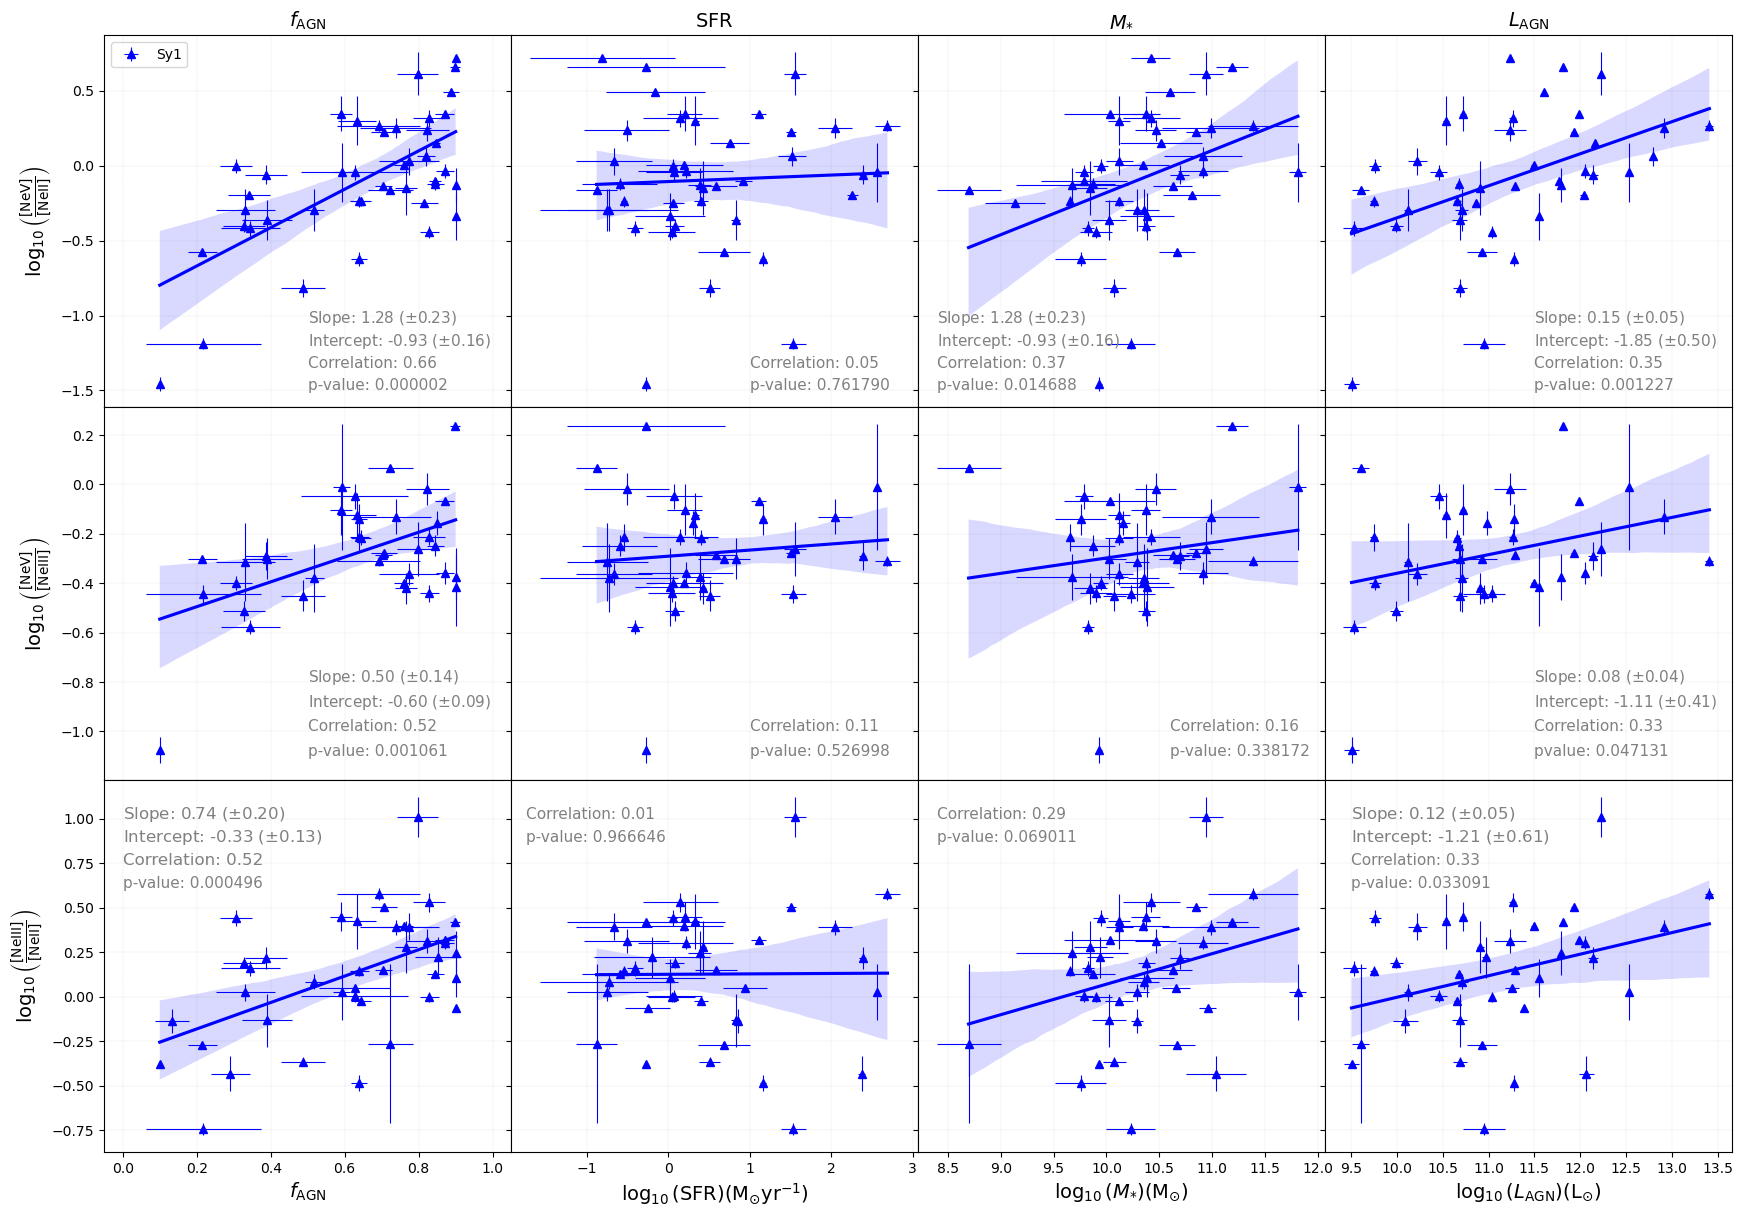

In [17]:
fig, axs = plt.subplots(3,4,figsize=(21,14.5),sharey='row',sharex='col')
#[NeV]/[NeII]vsfAGN------------------------------------------------------------------------
axs[0,0].errorbar(r1_Sy1['bayes.agn.fracAGN'],r1_Sy1['log_[NeV]/[NeII]'],
                  r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=axs[0,0],marker='*',color='b',scatter_kws={'s':2})
axs[0,0].set_xlim(-0.05,1.05)
axs[0,0].legend()
axs[0,0].set_title(r'$f_{\mathregular{AGN}}$', fontsize=14)
axs[0,0].text(0.5,-1.05,'Slope: %.2f' %r1Sy1_fAGN_linreg.slope+
              ' ($\pm$%.2f'%r1Sy1_fAGN_linreg.stderr+')',fontsize=11,color='gray')
axs[0,0].text(0.5,-1.2,'Intercept: %.2f' %r1Sy1_fAGN_linreg.intercept+
              ' ($\pm$%.2f'%r1Sy1_fAGN_linreg.intercept_stderr+')',fontsize=11,color='gray')
axs[0,0].text(0.5,-1.35,'Correlation: %.2f' %r1Sy1_fAGN_linreg.rvalue,fontsize=11,color='gray')
axs[0,0].text(0.5,-1.5,'p-value: %f' %r1Sy1_fAGN_linreg.pvalue,fontsize=11,color='gray')
#[NeV]/[NeII]vsSFR-------------------------------------------------------------------------
axs[0,1].errorbar(r1_Sy1['log_bayes.sfh.sfr'],r1_Sy1['log_[NeV]/[NeII]'],
                  r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=axs[0,1],marker='*',color='b',scatter_kws={'s':2})
axs[0,1].set_title(r'$\mathregular{SFR}$', fontsize=14)
axs[0,1].text(1,-1.35,'Correlation: %.2f' %r1Sy1_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[0,1].text(1,-1.5,'p-value: %f' %r1Sy1_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[0,1].set(ylabel=None)
#[NeV]/[NeII]vsM*---------------------------------------------------------------------------
axs[0,2].errorbar(r1_Sy1['log_bayes.stellar.m_star'],r1_Sy1['log_[NeV]/[NeII]'],
                  r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['log_bayes.stellar.m_star_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=axs[0,2],marker='*',color='b',scatter_kws={'s':2})
axs[0,2].set_title(r'$M_{*}$', fontsize=14)
axs[0,2].text(8.4,-1.05,'Slope: %.2f' %r1Sy1_fAGN_linreg.slope+
              ' ($\pm$%.2f'%r1Sy1_fAGN_linreg.stderr+')',fontsize=11,color='gray')
axs[0,2].text(8.4,-1.2,'Intercept: %.2f' %r1Sy1_fAGN_linreg.intercept+
              ' ($\pm$%.2f'%r1Sy1_fAGN_linreg.intercept_stderr+')',fontsize=11,color='gray')
axs[0,2].text(8.4,-1.35,'Correlation: %.2f' %r1Sy1_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[0,2].text(8.4,-1.5,'p-value: %f' %r1Sy1_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[0,2].set(ylabel=None)
#[NeV]/[NeII]vsLAGN-------------------------------------------------------------------------
axs[0,3].errorbar(r1_Sy1['log_bayes.agn.luminosity'],r1_Sy1['log_[NeV]/[NeII]'],
                  r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=axs[0,3],marker='*',color='b',scatter_kws={'s':2})
axs[0,3].set_title(r'$L_{\mathregular{AGN}}$', fontsize=14)
axs[0,3].text(11.5,-1.05,'Slope: %.2f' %r1Sy1_LAGN_linreg.slope+
              ' ($\pm$%.2f'%r1Sy1_LAGN_linreg.stderr+')',fontsize=11,color='gray')
axs[0,3].text(11.5,-1.2,'Intercept: %.2f' %r1Sy1_LAGN_linreg.intercept+
              ' ($\pm$%.2f'%r1Sy1_LAGN_linreg.intercept_stderr+')',fontsize=11,color='gray')
axs[0,3].text(11.5,-1.35,'Correlation: %.2f' %r1Sy1_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[0,3].text(11.5,-1.5,'p-value: %f' %r1Sy1_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[0,3].set(ylabel=None)
#------------------------------------------------------------------------------------------
#[NeV]/[NeIII]vsfAGN-----------------------------------------------------------------------
axs[1,0].errorbar(r2_Sy1['bayes.agn.fracAGN'],r2_Sy1['log_[NeV]/[NeIII]'],
                  r2_Sy1['log_[NeV]/[NeIII]_err'],r2_Sy1['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='bayes.agn.fracAGN', y="log_[NeV]/[NeIII]",data=r2_Sy1,
            ax=axs[1,0],marker='*',color='b',scatter_kws={'s':2})
axs[1,0].text(0.5,-0.8,'Slope: %.2f' %r2Sy1_fAGN_linreg.slope+
              ' ($\pm$%.2f'%r2Sy1_fAGN_linreg.stderr+')',fontsize=11,color='gray')
axs[1,0].text(0.5,-0.9,'Intercept: %.2f' %r2Sy1_fAGN_linreg.intercept+
              ' ($\pm$%.2f'%r2Sy1_fAGN_linreg.intercept_stderr+')',fontsize=11,color='gray')
axs[1,0].text(0.5,-1.0,'Correlation: %.2f' %r2Sy1_fAGN_linreg.rvalue,fontsize=11,color='gray')
axs[1,0].text(0.5,-1.1,'p-value: %f' %r2Sy1_fAGN_linreg.pvalue,fontsize=11,color='gray')
axs[1,0].set(xlabel=None)
axs[1,0].set(ylabel=None)
#[NeV]/[NeIII]vsSFR-------------------------------------------------------------------------
axs[1,1].errorbar(r2_Sy1['log_bayes.sfh.sfr'],r2_Sy1['log_[NeV]/[NeIII]'],
                  r2_Sy1['log_[NeV]/[NeIII]_err'],r2_Sy1['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeV]/[NeIII]",data=r2_Sy1,
            ax=axs[1,1],marker='*',color='b',scatter_kws={'s':2})
axs[1,1].text(1,-1.0,'Correlation: %.2f' %r2Sy1_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[1,1].text(1,-1.1,'p-value: %f' %r2Sy1_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[1,1].set(xlabel=None)
axs[1,1].set(ylabel=None)
#[NeV]/[NeIII]vsM*--------------------------------------------------------------------------
axs[1,2].errorbar(r2_Sy1['log_bayes.stellar.m_star'],r2_Sy1['log_[NeV]/[NeIII]'],
                  r2_Sy1['log_[NeV]/[NeIII]_err'],r2_Sy1['log_bayes.stellar.m_star_err'],
                markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeV]/[NeIII]",data=r2_Sy1,
            ax=axs[1,2],marker='*',color='b',scatter_kws={'s':2})
axs[1,2].text(10.6,-1.0,'Correlation: %.2f' %r2Sy1_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[1,2].text(10.6,-1.1,'p-value: %f' %r2Sy1_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[1,2].set(xlabel=None)
axs[1,2].set(ylabel=None)
#[NeV]/[NeIII]vsLAGN------------------------------------------------------------------------
axs[1,3].errorbar(r2_Sy1['log_bayes.agn.luminosity'],r2_Sy1['log_[NeV]/[NeIII]'],
                  r2_Sy1['log_[NeV]/[NeIII]_err'],r2_Sy1['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeV]/[NeIII]",data=r2_Sy1,
            ax=axs[1,3],marker='*',color='b',scatter_kws={'s':2})
axs[1,3].text(11.5,-0.8,'Slope: %.2f' %r2Sy1_LAGN_linreg.slope+
              ' ($\pm$%.2f'%r2Sy1_LAGN_linreg.stderr+')',fontsize=11,color='gray')
axs[1,3].text(11.5,-0.9,'Intercept: %.2f' %r2Sy1_LAGN_linreg.intercept+
              ' ($\pm$%.2f'%r2Sy1_LAGN_linreg.intercept_stderr+')',fontsize=11,color='gray')
axs[1,3].text(11.5,-1.0,'Correlation: %.2f' %r2Sy1_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[1,3].text(11.5,-1.1,'pvalue: %f' %r2Sy1_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[1,3].set(ylabel=None)
#-------------------------------------------------------------------------------------------
#[NeIII]/[NeII]vsfAGN----------------------------------------------------------------------
axs[2,0].errorbar(r3_Sy1['bayes.agn.fracAGN'],r3_Sy1['log_[NeIII]/[NeII]'],
                  r3_Sy1['log_[NeIII]/[NeII]_err'],r3_Sy1['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeIII]/[NeII]",data=r3_Sy1,
            ax=axs[2,0],marker='*',color='b',scatter_kws={'s':2})
axs[2,0].text(0.0,1.0,'Slope: %.2f' %r3Sy1_fAGN_linreg.slope+
              ' ($\pm$%.2f'%r3Sy1_fAGN_linreg.stderr+')',fontsize=12,color='gray')
axs[2,0].text(0.0,0.87,'Intercept: %.2f' %r3Sy1_fAGN_linreg.intercept+
              ' ($\pm$%.2f'%r3Sy1_fAGN_linreg.intercept_stderr+')',fontsize=12,color='gray')
axs[2,0].text(0.0,0.74,'Correlation: %.2f' %r3Sy1_fAGN_linreg.rvalue,fontsize=12,color='gray')
axs[2,0].text(0.0,0.61,'p-value: %f' %r3Sy1_fAGN_linreg.pvalue,fontsize=11,color='gray')
axs[2,0].set(xlabel=None)
axs[2,0].set(ylabel=None)
#[NeIII]/[NeII]vsSFR------------------------------------------------------------------------
axs[2,1].errorbar(r3_Sy1['log_bayes.sfh.sfr'],r3_Sy1['log_[NeIII]/[NeII]'],
                  r3_Sy1['log_[NeIII]/[NeII]_err'],r3_Sy1['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeIII]/[NeII]",data=r3_Sy1,
            ax=axs[2,1],marker='*',color='b',scatter_kws={'s':2})
axs[2,1].text(-1.75,1.0,'Correlation: %.2f' %r3Sy1_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[2,1].text(-1.75,0.87,'p-value: %f' %r3Sy1_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[2,1].set(xlabel=None)
axs[2,1].set(ylabel=None)
#[NeIII]/[NeII]vsM*-------------------------------------------------------------------------
axs[2,2].errorbar(r3_Sy1['log_bayes.stellar.m_star'],r3_Sy1['log_[NeIII]/[NeII]'],
                  r3_Sy1['log_[NeIII]/[NeII]_err'],r3_Sy1['log_bayes.stellar.m_star_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeIII]/[NeII]",data=r3_Sy1,
            ax=axs[2,2],marker='*',color='b',scatter_kws={'s':2})
axs[2,2].text(8.4,1.0,'Correlation: %.2f' %r3Sy1_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[2,2].text(8.4,0.87,'p-value: %f' %r3Sy1_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[2,2].set(xlabel=None)
axs[2,2].set(ylabel=None)
#[NeIII]/[NeII]vsLAGN-----------------------------------------------------------------------
axs[2,3].errorbar(r3_Sy1['log_bayes.agn.luminosity'],r3_Sy1['log_[NeIII]/[NeII]'],
                  r3_Sy1['log_[NeIII]/[NeII]_err'],r3_Sy1['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeIII]/[NeII]",data=r3_Sy1,
            ax=axs[2,3],marker='*',color='b',scatter_kws={'s':2})
axs[2,3].text(9.5,1.0,'Slope: %.2f' %r3Sy1_LAGN_linreg.slope+
              ' ($\pm$%.2f'%r3Sy1_LAGN_linreg.stderr+')',fontsize=12,color='gray')
axs[2,3].text(9.5,0.87,'Intercept: %.2f' %r3Sy1_LAGN_linreg.intercept+
              ' ($\pm$%.2f'%r3Sy1_LAGN_linreg.intercept_stderr+')',fontsize=12,color='gray')
axs[2,3].text(9.5,0.74,'Correlation: %.2f' %r3Sy1_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[2,3].text(9.5,0.61,'p-value: %f' %r3Sy1_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[2,3].set(ylabel=None)
#-------------------------------------------------------------------------------------------
#ylabels-------------------------------------------------------------------------------------
axs[2,0].set_xlabel(r'$f_{\mathregular{AGN}}$',fontsize=14)
axs[2,1].set_xlabel(r'$\log_{10}(\mathregular{SFR})(\mathregular{M}_{\odot} \mathregular{yr}^{-1})$',
                    fontsize=14)
axs[2,2].set_xlabel(r'$\log_{10}(M_{*})(\mathregular{M}_{\odot})$',fontsize=14)
axs[2,3].set_xlabel(r'$\log_{10}(L_{\mathregular{AGN}})(\mathregular{L}_{\odot})$',fontsize=14)
#xlabels-------------------------------------------------------------------------------------
axs[0,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',
                    fontsize=14)
axs[1,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeIII]}}\right)$',
                    fontsize=14)
axs[2,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeIII]}}{\mathregular{[NeII]}}\right)$',
                    fontsize=14)
#Grid----------------------------------------------------------------------------------------
for i in range(3):
    for j in range(4):
        axs[i,j].grid(color='k', linestyle='--', linewidth=0.04)

plt.subplots_adjust(wspace=0.0) #Space between subplots
plt.subplots_adjust(hspace=0.0) #Space between subplots
plt.savefig(path_graphs+'Ne_ratios_vs_CIGALEresults_Sy1.jpg')

For Seyfert 2 galaxies:

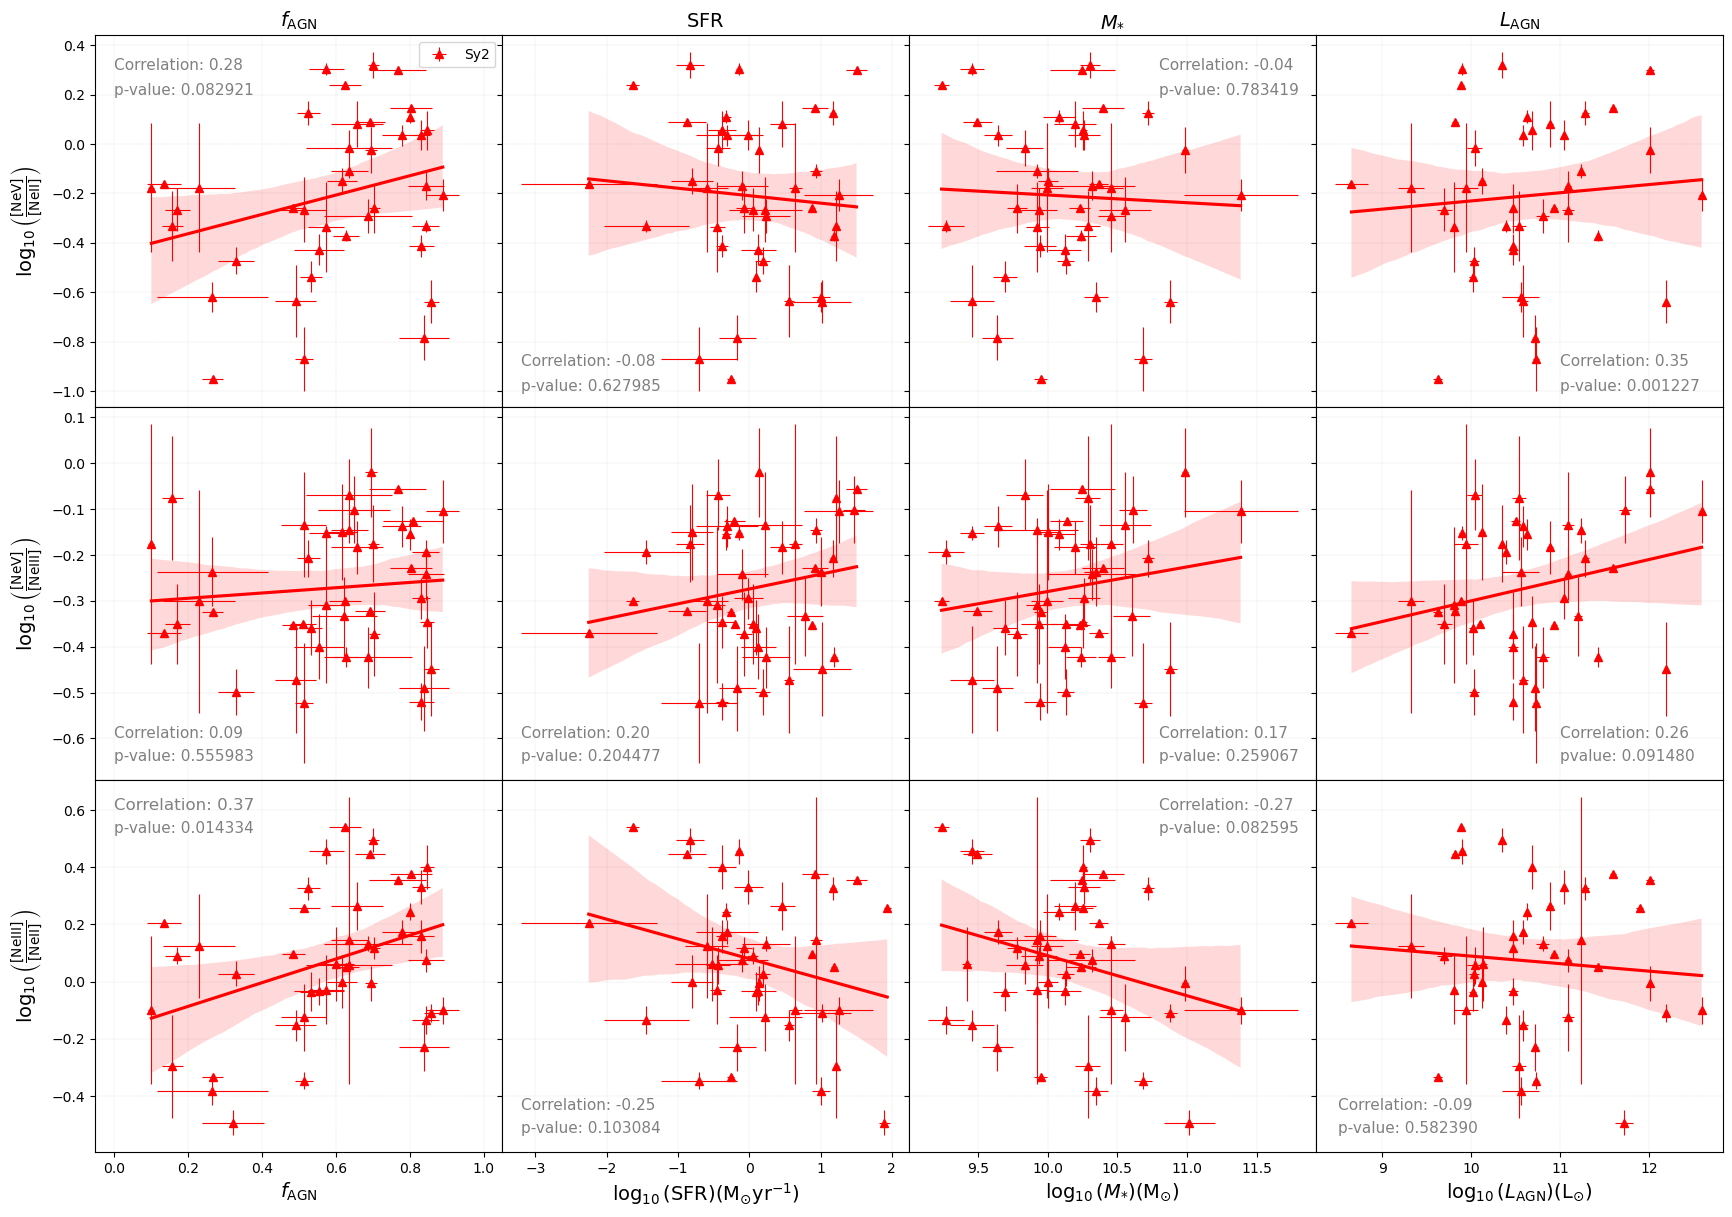

In [18]:
fig, axs = plt.subplots(3,4,figsize=(21,14.5),sharey='row',sharex='col')
#[NeV]/[NeII]vsfAGN------------------------------------------------------------------------
axs[0,0].errorbar(r1_Sy2['bayes.agn.fracAGN'],r1_Sy2['log_[NeV]/[NeII]'],
                  r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=axs[0,0],marker='*',color='r',scatter_kws={'s':2})
axs[0,0].set_xlim(-0.05,1.05)
axs[0,0].legend()
axs[0,0].set_title(r'$f_{\mathregular{AGN}}$', fontsize=14)
axs[0,0].text(0.0,0.3,'Correlation: %.2f' %r1Sy2_fAGN_linreg.rvalue,fontsize=11,color='gray')
axs[0,0].text(0.0,0.2,'p-value: %f' %r1Sy2_fAGN_linreg.pvalue,fontsize=11,color='gray')
axs[0,0].set(xlabel=None)
#[NeV]/[NeII]vsSFR-------------------------------------------------------------------------
axs[0,1].errorbar(r1_Sy2['log_bayes.sfh.sfr'],r1_Sy2['log_[NeV]/[NeII]'],
                  r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=axs[0,1],marker='*',color='r',scatter_kws={'s':2})
axs[0,1].set_title(r'$\mathregular{SFR}$', fontsize=14)
axs[0,1].text(-3.2,-0.9,'Correlation: %.2f' %r1Sy2_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[0,1].text(-3.2,-1.0,'p-value: %f' %r1Sy2_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[0,1].set(ylabel=None)
#[NeV]/[NeII]vsM*---------------------------------------------------------------------------
axs[0,2].errorbar(r1_Sy2['log_bayes.stellar.m_star'],r1_Sy2['log_[NeV]/[NeII]'],
                  r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['log_bayes.stellar.m_star_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=axs[0,2],marker='*',color='r',scatter_kws={'s':2})
axs[0,2].set_title(r'$M_{*}$', fontsize=14)
axs[0,2].text(10.8,0.3,'Correlation: %.2f' %r1Sy2_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[0,2].text(10.8,0.2,'p-value: %f' %r1Sy2_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[0,2].set(ylabel=None)
#[NeV]/[NeII]vsLAGN-------------------------------------------------------------------------
axs[0,3].errorbar(r1_Sy2['log_bayes.agn.luminosity'],r1_Sy2['log_[NeV]/[NeII]'],
                  r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=axs[0,3],marker='*',color='r',scatter_kws={'s':2})
axs[0,3].set_title(r'$L_{\mathregular{AGN}}$', fontsize=14)
axs[0,3].text(11,-0.9,'Correlation: %.2f' %r1Sy2_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[0,3].text(11,-1.0,'p-value: %f' %r1Sy2_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[0,3].set(ylabel=None)
#------------------------------------------------------------------------------------------
#[NeV]/[NeIII]vsfAGN-----------------------------------------------------------------------
axs[1,0].errorbar(r2_Sy2['bayes.agn.fracAGN'],r2_Sy2['log_[NeV]/[NeIII]'],
                  r2_Sy2['log_[NeV]/[NeIII]_err'],r2_Sy2['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='bayes.agn.fracAGN', y="log_[NeV]/[NeIII]",data=r2_Sy2,
            ax=axs[1,0],marker='*',color='r',scatter_kws={'s':2})
axs[1,0].text(0.0,-0.6,'Correlation: %.2f' %r2Sy2_fAGN_linreg.rvalue,fontsize=11,color='gray')
axs[1,0].text(0.0,-0.65,'p-value: %f' %r2Sy2_fAGN_linreg.pvalue,fontsize=11,color='gray')
axs[1,0].set(xlabel=None)
axs[1,0].set(ylabel=None)
#[NeV]/[NeIII]vsSFR-------------------------------------------------------------------------
axs[1,1].errorbar(r2_Sy2['log_bayes.sfh.sfr'],r2_Sy2['log_[NeV]/[NeIII]'],
                  r2_Sy2['log_[NeV]/[NeIII]_err'],r2_Sy2['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeV]/[NeIII]",data=r2_Sy2,
            ax=axs[1,1],marker='*',color='r',scatter_kws={'s':2})
axs[1,1].text(-3.2,-0.6,'Correlation: %.2f' %r2Sy2_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[1,1].text(-3.2,-0.65,'p-value: %f' %r2Sy2_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[1,1].set(xlabel=None)
axs[1,1].set(ylabel=None)
#[NeV]/[NeIII]vsM*--------------------------------------------------------------------------
axs[1,2].errorbar(r2_Sy2['log_bayes.stellar.m_star'],r2_Sy2['log_[NeV]/[NeIII]'],
                  r2_Sy2['log_[NeV]/[NeIII]_err'],r2_Sy2['log_bayes.stellar.m_star_err'],
                markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeV]/[NeIII]",data=r2_Sy2,
            ax=axs[1,2],marker='*',color='r',scatter_kws={'s':2})
axs[1,2].text(10.8,-0.6,'Correlation: %.2f' %r2Sy2_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[1,2].text(10.8,-0.65,'p-value: %f' %r2Sy2_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[1,2].set(xlabel=None)
axs[1,2].set(ylabel=None)
#[NeV]/[NeIII]vsLAGN------------------------------------------------------------------------
axs[1,3].errorbar(r2_Sy2['log_bayes.agn.luminosity'],r2_Sy2['log_[NeV]/[NeIII]'],
                  r2_Sy2['log_[NeV]/[NeIII]_err'],r2_Sy2['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeV]/[NeIII]",data=r2_Sy2,
            ax=axs[1,3],marker='*',color='r',scatter_kws={'s':2})
axs[1,3].text(11,-0.6,'Correlation: %.2f' %r2Sy2_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[1,3].text(11,-0.65,'pvalue: %f' %r2Sy2_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[1,3].set(ylabel=None)
#-------------------------------------------------------------------------------------------
#[NeIII]/[NeII]vsfAGN----------------------------------------------------------------------
axs[2,0].errorbar(r3_Sy2['bayes.agn.fracAGN'],r3_Sy2['log_[NeIII]/[NeII]'],
                  r3_Sy2['log_[NeIII]/[NeII]_err'],r3_Sy2['bayes.agn.fracAGN_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeIII]/[NeII]",data=r3_Sy2,
            ax=axs[2,0],marker='*',color='r',scatter_kws={'s':2})
axs[2,0].text(0.0,0.6,'Correlation: %.2f' %r3Sy2_fAGN_linreg.rvalue,fontsize=12,color='gray')
axs[2,0].text(0.0,0.52,'p-value: %f' %r3Sy2_fAGN_linreg.pvalue,fontsize=11,color='gray')
axs[2,0].set(xlabel=None)
axs[2,0].set(ylabel=None)
#[NeIII]/[NeII]vsSFR------------------------------------------------------------------------
axs[2,1].errorbar(r3_Sy2['log_bayes.sfh.sfr'],r3_Sy2['log_[NeIII]/[NeII]'],
                  r3_Sy2['log_[NeIII]/[NeII]_err'],r3_Sy2['log_bayes.sfh.sfr_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.sfh.sfr',y="log_[NeIII]/[NeII]",data=r3_Sy2,
            ax=axs[2,1],marker='*',color='r',scatter_kws={'s':2})
axs[2,1].text(-3.2,-0.45,'Correlation: %.2f' %r3Sy2_SFR_linreg.rvalue,fontsize=11,color='gray')
axs[2,1].text(-3.2,-0.53,'p-value: %f' %r3Sy2_SFR_linreg.pvalue,fontsize=11,color='gray')
axs[2,1].set(xlabel=None)
axs[2,1].set(ylabel=None)
#[NeIII]/[NeII]vsM*-------------------------------------------------------------------------
axs[2,2].errorbar(r3_Sy2['log_bayes.stellar.m_star'],r3_Sy2['log_[NeIII]/[NeII]'],
                  r3_Sy2['log_[NeIII]/[NeII]_err'],r3_Sy2['log_bayes.stellar.m_star_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.stellar.m_star',y="log_[NeIII]/[NeII]",data=r3_Sy2,
            ax=axs[2,2],marker='*',color='r',scatter_kws={'s':2})
axs[2,2].text(10.8,0.6,'Correlation: %.2f' %r3Sy2_Mstar_linreg.rvalue,fontsize=11,color='gray')
axs[2,2].text(10.8,0.52,'p-value: %f' %r3Sy2_Mstar_linreg.pvalue,fontsize=11,color='gray')
axs[2,2].set(xlabel=None)
axs[2,2].set(ylabel=None)
#[NeIII]/[NeII]vsLAGN-----------------------------------------------------------------------
axs[2,3].errorbar(r3_Sy2['log_bayes.agn.luminosity'],r3_Sy2['log_[NeIII]/[NeII]'],
                  r3_Sy2['log_[NeIII]/[NeII]_err'],r3_Sy2['log_bayes.agn.luminosity_err'],
                  markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
sns.regplot(x='log_bayes.agn.luminosity',y="log_[NeIII]/[NeII]",data=r3_Sy2,
            ax=axs[2,3],marker='*',color='r',scatter_kws={'s':2})
axs[2,3].text(8.5,-0.45,'Correlation: %.2f' %r3Sy2_LAGN_linreg.rvalue,fontsize=11,color='gray')
axs[2,3].text(8.5,-0.53,'p-value: %f' %r3Sy2_LAGN_linreg.pvalue,fontsize=11,color='gray')
axs[2,3].set(ylabel=None)
#-------------------------------------------------------------------------------------------
#ylabels-------------------------------------------------------------------------------------
axs[2,0].set_xlabel(r'$f_{\mathregular{AGN}}$',fontsize=14)
axs[2,1].set_xlabel(r'$\log_{10}(\mathregular{SFR})(\mathregular{M}_{\odot} \mathregular{yr}^{-1})$',
                    fontsize=14)
axs[2,2].set_xlabel(r'$\log_{10}(M_{*})(\mathregular{M}_{\odot})$',fontsize=14)
axs[2,3].set_xlabel(r'$\log_{10}(L_{\mathregular{AGN}})(\mathregular{L}_{\odot})$',fontsize=14)
#xlabels-------------------------------------------------------------------------------------
axs[0,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',
                    fontsize=14)
axs[1,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeIII]}}\right)$',
                    fontsize=14)
axs[2,0].set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeIII]}}{\mathregular{[NeII]}}\right)$',
                    fontsize=14)
#Grid----------------------------------------------------------------------------------------
for i in range(3):
    for j in range(4):
        axs[i,j].grid(color='k', linestyle='--', linewidth=0.04)

plt.subplots_adjust(wspace=0.0) #Space between subplots
plt.subplots_adjust(hspace=0.0) #Space between subplots
plt.savefig(path_graphs+'Ne_ratios_vs_CIGALEresults_Sy2.jpg')

----------------------------------------

## Bootstraping Correlation Coefficients for [NeV]/[NeII] vs AGN Fraction

With the function bootstrapCorr in bootstrap_corr.py (imported as bsc at the begining of this notebook) we compute the correlation coefficient with bootstrapping

In [19]:
r1_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,r1_Sy,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_Sy[0]),'max:',max(r1_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 67 of 84
Number of samples: 10000
Median: 0.5439912947843738
Mean: 0.5360485515221973
Variance: 0.008914017929030986
Standard Desviation: 0.09441407696435414
95 % confidence interval: 0.37023533279860665 - 0.6788795701510663
min: 0.06715935026504176 max: 0.7981414624960679


In [20]:
r1_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,r1_Sy1,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_Sy1[0]),'max:',max(r1_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 34 of 43
Number of samples: 10000
Median: 0.6570748451490072
Mean: 0.6412080833161525
Variance: 0.012838379120668183
Standard Desviation: 0.11330657139225501
95 % confidence interval: 0.42982560356885824 - 0.7967050257256656
min: 0.035084556733478496 max: 0.9183009315375801


In [21]:
r1_fracAGN_Sy2 = bsc.bootstrapCorr(10000,0.8,r1_Sy2,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_Sy2[0]),'max:',max(r1_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 32 of 40
Number of samples: 10000
Median: 0.28397757318900924
Mean: 0.2788320762452205
Variance: 0.021400146651701545
Standard Desviation: 0.14628788962761594
95 % confidence interval: 0.03137308815303474 - 0.515522251098894
min: -0.28919229964314486 max: 0.7557098175870782


Some common parameters for the graphics of the Neon Line Ratios vs $f_{AGN}$:

In [22]:
#Labels text and fontsize for the graphics of Ne Ratios vs fAGN:
xl_label = r'$f_{\mathregular{AGN}}$'
xr_label = r'Pearson correlation coefficient (PCC)'
yl_label = r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$'
yr_label = r'Density'
fontsize_labels = 12

#Aggregate statistic to compute in each bin in the histograms
#Options: count, frequency, probability, percent and density
stat = 'density'

#fAGN range
fAGN_range = np.linspace(min(r1_Sy['bayes.agn.fracAGN']),max(r1_Sy['bayes.agn.fracAGN']),len(r1_Sy['bayes.agn.fracAGN']))

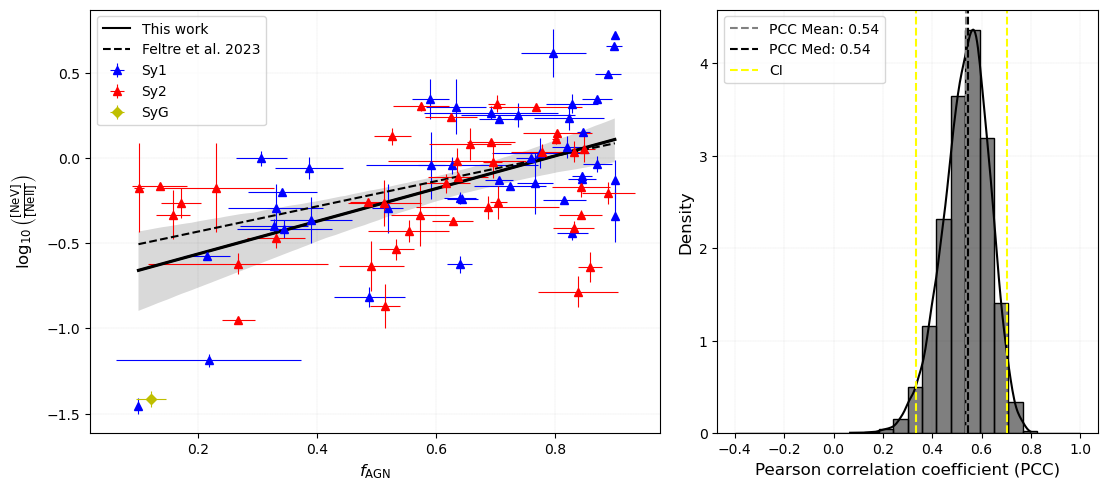

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5.5),
                               gridspec_kw={'width_ratios': [3,2]})

bins = np.linspace(-0.4,1.0,25)

ax1 = plt.subplot(121)
ax1.errorbar(r1_Sy1['bayes.agn.fracAGN'],r1_Sy1['log_[NeV]/[NeII]'],
             r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(r1_Sy2['bayes.agn.fracAGN'],r1_Sy2['log_[NeV]/[NeII]'],
             r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
ax1.errorbar(r1_SyG['bayes.agn.fracAGN'],r1_SyG['log_[NeV]/[NeII]'],
             r1_SyG['log_[NeV]/[NeII]_err'],r1_SyG['bayes.agn.fracAGN_err'],
             markersize=5,elinewidth=0.8,fmt='yD',label='SyG')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy,
            marker='*',color='k',ax=ax1,scatter_kws={'s':2})
ax1.plot(fAGN_range,r1_fAGN_linreg.slope*fAGN_range+
         r1_fAGN_linreg.intercept,'-k',label='This work')
ax1.plot(fAGN_range,0.74*fAGN_range-
         0.58,'--k',label='Feltre et al. 2023')
ax1.set_xlabel(xl_label,fontsize=fontsize_labels)
ax1.set_ylabel(yl_label,fontsize=fontsize_labels)
ax1.grid(color='k', linestyle='--', linewidth=0.04)
ax1.legend()

ax2 = plt.subplot(122)
sns.histplot(r1_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax2)
ax2.axvline(x=r1_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy[1])
ax2.axvline(x=r1_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy[3])
ax2.axvline(x=r1_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax2.axvline(x=r1_fracAGN_Sy[5],ls='--',color='yellow')
ax2.set_xlabel(xr_label,fontsize=fontsize_labels)
ax2.set_ylabel(yr_label,fontsize=fontsize_labels)
ax2.grid(color='k', linestyle='--', linewidth=0.04)
ax2.legend()

plt.subplots_adjust(hspace=0.0,wspace=0.12) #Space between subplots

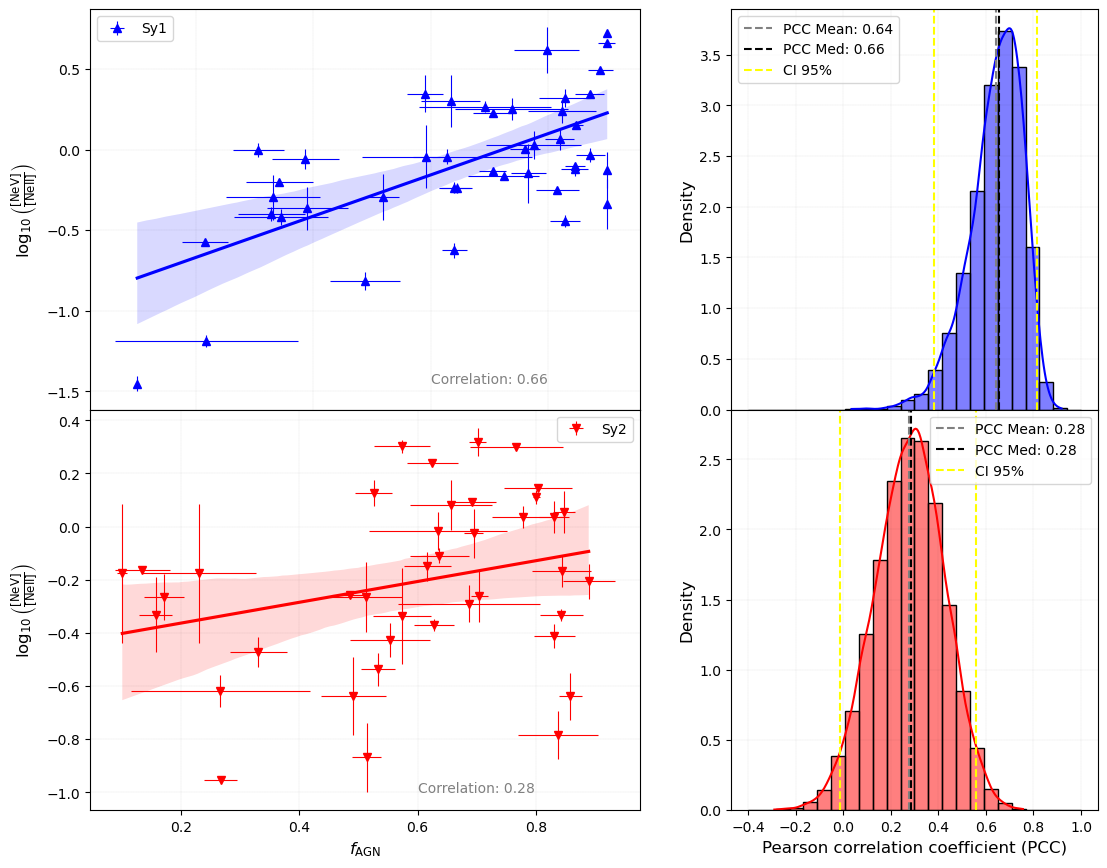

In [24]:
#plt.figure(figsize=(10,6.67))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(13,10.4),gridspec_kw={'width_ratios': [3,2]})

ax1 = plt.subplot(221)
ax1.errorbar(r1_Sy1['bayes.agn.fracAGN'],r1_Sy1['log_[NeV]/[NeII]'],
                r1_Sy1['log_[NeV]/[NeII]_err'], r1_Sy1['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=ax1,marker='*',color='b',scatter_kws={'s':2})
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.text(0.6,-1.45,'Correlation: %.2f' %r1Sy1_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.04)

ax2 = plt.subplot(222)
sns.histplot(r1_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax2)
ax2.axvline(x=r1_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy1[1])
ax2.axvline(x=r1_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy1[3])
ax2.axvline(x=r1_fracAGN_Sy1[4],ls='--',color='yellow',label='CI 95%')
ax2.axvline(x=r1_fracAGN_Sy1[5],ls='--',color='yellow')
ax2.set_ylabel(yr_label,fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.04)

ax3 = plt.subplot(223)#,sharex=ax1,sharey=ax1
ax3.errorbar(r1_Sy2['bayes.agn.fracAGN'],r1_Sy2['log_[NeV]/[NeII]'],
                r1_Sy2['log_[NeV]/[NeII]_err'], r1_Sy2['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='rv',label='Sy2')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=ax3,marker='*',color='r',scatter_kws={'s':2})
ax3.set_xlabel(xl_label,
               fontsize=fontsize_labels)
ax3.text(0.6,-1.0,'Correlation: %.2f' %r1Sy2_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.04)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(r1_fracAGN_Sy[0])
binsSy1 = sturges(r1_fracAGN_Sy1[0])
binsSy2 = sturges(r1_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(224)#,sharex=ax2,sharey=ax2
sns.histplot(r1_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax4)
ax4.axvline(x=r1_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy2[1])
ax4.axvline(x=r1_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy2[3])
ax4.axvline(x=r1_fracAGN_Sy2[4],ls='--',color='yellow',label='CI 95%')
ax4.axvline(x=r1_fracAGN_Sy2[5],ls='--',color='yellow')
ax4.set_xlabel(xr_label,fontsize=fontsize_labels)
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.04)


plt.subplots_adjust(hspace=0.0,wspace=0.2) #Space between subplots
plt.savefig(path_graphs+'NeV_NeII_vs_fracAGN_Sy1_vs_Sy2.jpg')

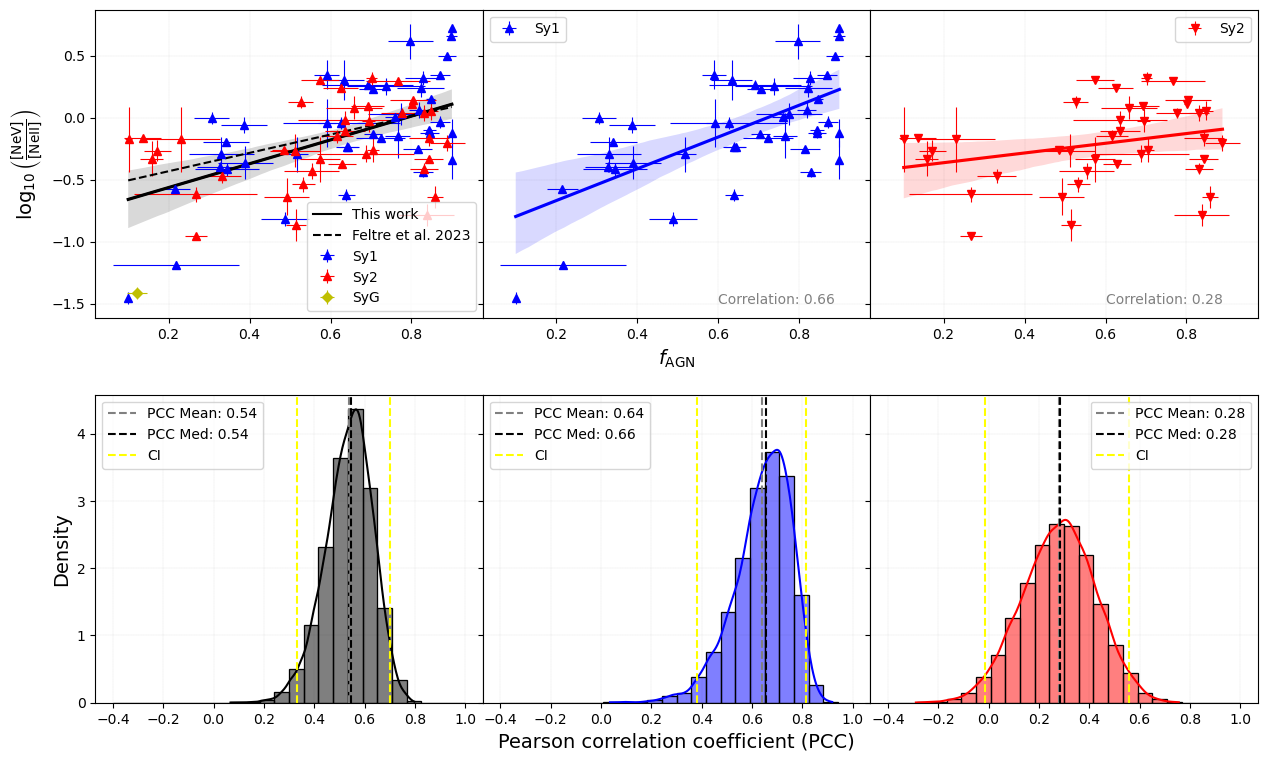

In [25]:
plt.figure(figsize=(15,9))

ax1 = plt.subplot(231)
ax1.errorbar(r1_Sy1['bayes.agn.fracAGN'],r1_Sy1['log_[NeV]/[NeII]'],
             r1_Sy1['log_[NeV]/[NeII]_err'],r1_Sy1['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(r1_Sy2['bayes.agn.fracAGN'],r1_Sy2['log_[NeV]/[NeII]'],
             r1_Sy2['log_[NeV]/[NeII]_err'],r1_Sy2['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='r^',label='Sy2')
ax1.errorbar(r1_SyG['bayes.agn.fracAGN'],r1_SyG['log_[NeV]/[NeII]'],
             r1_SyG['log_[NeV]/[NeII]_err'],r1_SyG['bayes.agn.fracAGN_err'],
             markersize=5,elinewidth=0.8,fmt='yD',label='SyG')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy,
            marker='*',color='k',ax=ax1,scatter_kws={'s':2})
ax1.plot(fAGN_range,r1_fAGN_linreg.slope*fAGN_range+
         r1_fAGN_linreg.intercept,'-k',label='This work')
ax1.plot(fAGN_range,0.74*fAGN_range-
         0.58,'--k',label='Feltre et al. 2023')
#ax1.set_xlabel(xl_label,fontsize=fontsize_labels)
ax1.set_ylabel(yl_label,fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.04)
ax1.set(xlabel=None)
ax1.legend()

ax2 = plt.subplot(232,sharex=ax1,sharey=ax1)
ax2.errorbar(r1_Sy1['bayes.agn.fracAGN'],r1_Sy1['log_[NeV]/[NeII]'],
                r1_Sy1['log_[NeV]/[NeII]_err'], r1_Sy1['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='b^',label='Sy1')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy1,
            ax=ax2,marker='*',color='b',scatter_kws={'s':2})
ax2.set_xlabel(xl_label,
               fontsize=14)
ax2.yaxis.set_tick_params(labelleft=False)
ax2.set(ylabel=None)
ax2.text(0.6,-1.5,'Correlation: %.2f' %r1Sy1_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.04)

ax3 = plt.subplot(233,sharex=ax1,sharey=ax1)
ax3.errorbar(r1_Sy2['bayes.agn.fracAGN'],r1_Sy2['log_[NeV]/[NeII]'],
                r1_Sy2['log_[NeV]/[NeII]_err'], r1_Sy2['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='rv',label='Sy2')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=r1_Sy2,
            ax=ax3,marker='*',color='r',scatter_kws={'s':2})
ax3.set_xlabel(xl_label,
               fontsize=14)
ax3.text(0.6,-1.5,'Correlation: %.2f' %r1Sy2_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax3.yaxis.set_tick_params(labelleft=False)
ax3.set(xlabel=None)
ax3.set(ylabel=None)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.04)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(r1_fracAGN_Sy[0])
binsSy1 = sturges(r1_fracAGN_Sy1[0])
binsSy2 = sturges(r1_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(234)
sns.histplot(r1_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4)
ax4.axvline(x=r1_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy[1])
ax4.axvline(x=r1_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy[3])
ax4.axvline(x=r1_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=r1_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=14)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.04)

ax5 = plt.subplot(235,sharex=ax4,sharey=ax4)
sns.histplot(r1_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5)
ax5.axvline(x=r1_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy1[1])
ax5.axvline(x=r1_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy1[3])
ax5.axvline(x=r1_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=r1_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_xlabel(xr_label,fontsize=14)
ax5.set(ylabel=None)
ax5.yaxis.set_tick_params(labelleft=False)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.04)

ax6 = plt.subplot(236,sharex=ax4,sharey=ax4)
sns.histplot(r1_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6)
ax6.axvline(x=r1_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_Sy2[1])
ax6.axvline(x=r1_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_Sy2[3])
ax6.axvline(x=r1_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=r1_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set(ylabel=None)
ax6.yaxis.set_tick_params(labelleft=False)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.04)

plt.subplots_adjust(hspace=0.25,wspace=0.0) #Space between subplots

--------------------------

# Classifying Seyfert galaxies according to their viewing angle $i$ and to their AGN disc luminosity $\left(L^{disc}_{AGN} \right)$, estimated from CIGALE

In [26]:
i_Sy1 = Ne_Sy1['bayes.agn.i']
if i_Sy1.dtype.byteorder == '>': #Check if data is big-endian
    i_Sy1 = i_Sy1.byteswap().newbyteorder() #if yes, convert it to little-endian
i_Sy2 = Ne_Sy2['bayes.agn.i']
if i_Sy2.dtype.byteorder == '>':
    i_Sy2 = i_Sy2.byteswap().newbyteorder() 

In [27]:
L_Sy1 = Ne_Sy1['log_bayes.agn.disk_luminosity']
if L_Sy1.dtype.byteorder == '>': #Check if data is big-endian
    L_Sy1 = L_Sy1.byteswap().newbyteorder() #if yes, convert it to little-endian
L_Sy2 = Ne_Sy2['log_bayes.agn.disk_luminosity']
if L_Sy2.dtype.byteorder == '>':
    L_Sy2 = L_Sy2.byteswap().newbyteorder() 

In [28]:
bins_Sy_i = np.linspace(min(Ne_Sy['bayes.agn.i']),
                        max(Ne_Sy['bayes.agn.i']),12)#len(Ne_Sy)
bins_Sy_L = np.linspace(min(Ne_Sy['log_bayes.agn.disk_luminosity']),
                        max(Ne_Sy['log_bayes.agn.disk_luminosity']),12)#len(Ne_Sy)

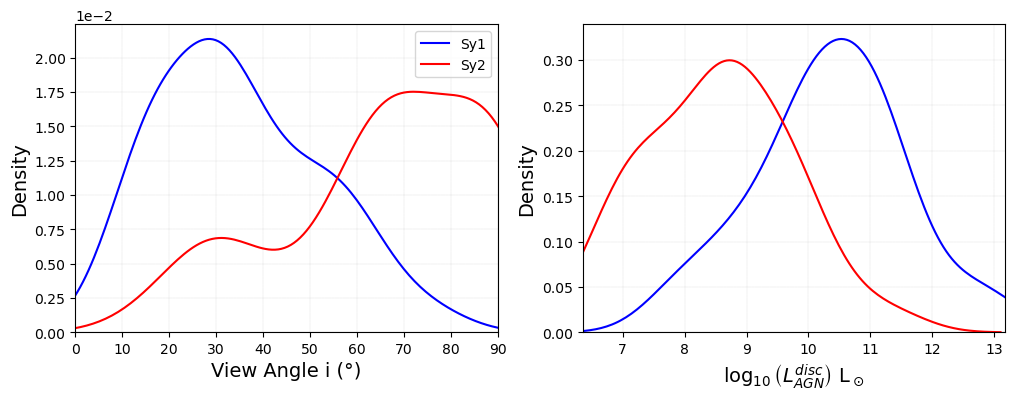

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))

sns.kdeplot(i_Sy1,label='Sy1',color='b',ax=ax1)
sns.kdeplot(i_Sy2,label='Sy2',color='r',ax=ax1)
ax1.set_xlabel(r'View Angle i (°)',fontsize=14)
ax1.set_ylabel(r'Density',fontsize=14)
ax1.set_xlim(0,90)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

sns.kdeplot(L_Sy1,label='Sy1',color='b',ax=ax2)
sns.kdeplot(L_Sy2,label='Sy2',color='r',ax=ax2)
ax2.set_xlabel(r'$\log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax2.set_ylabel(r'Density',fontsize=14)
ax2.set_xlim(min(Ne_Sy['log_bayes.agn.disk_luminosity']),max(Ne_Sy['log_bayes.agn.disk_luminosity']))
ax2.grid(color='k', linestyle='--', linewidth=0.05)

plt.subplots_adjust(wspace=0.20) #Space between subplots
plt.savefig(path_graphs+'hist_view_angle.jpg')

In [30]:
ks_2samp(i_Sy1,i_Sy2)

KstestResult(statistic=0.6843247937472862, pvalue=3.947576159656576e-11, statistic_location=59.34704859851327, statistic_sign=1)

In [31]:
ks_2samp(L_Sy1,L_Sy2)

KstestResult(statistic=0.60790273556231, pvalue=5.594847400398621e-09, statistic_location=9.782466461891259, statistic_sign=-1)

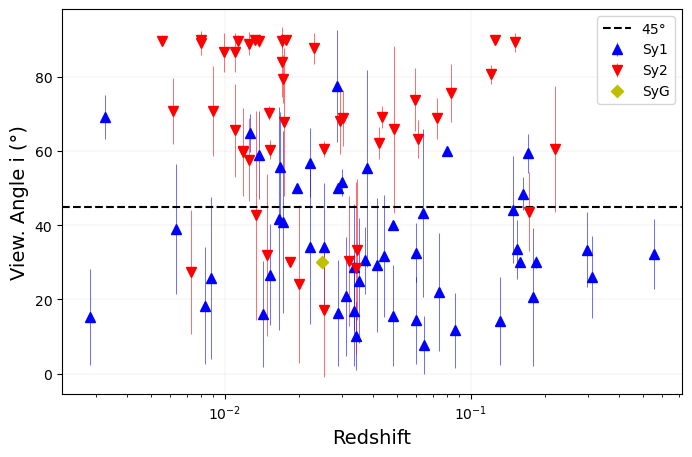

In [32]:
plt.figure(figsize=(8,5))
plt.errorbar(Ne_Sy1['redshift'],Ne_Sy1['bayes.agn.i'],Ne_Sy1['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='b^',label='Sy1')
plt.errorbar(Ne_Sy2['redshift'],Ne_Sy2['bayes.agn.i'],Ne_Sy2['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='rv',label='Sy2')
plt.errorbar(Ne_SyG['redshift'],Ne_SyG['bayes.agn.i'],Ne_SyG['bayes.agn.i_err'],markersize=6,elinewidth=0.4,fmt='yD',label='SyG')
plt.axhline(y=45,ls='--',color='black', label='45°')
plt.xlabel(r'Redshift',fontsize=14)
plt.xscale('log')
plt.ylabel(r'View. Angle i (°)',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()
plt.savefig(path_graphs+'view_angle_vs_redshift.jpg')

### Classifying the galaxies by their viewing angle:

In [33]:
AGN_T1 = r1_Sy[r1_Sy['bayes.agn.i']<45]
AGN_T2 = r1_Sy[r1_Sy['bayes.agn.i']>45]

In [34]:
print('For the',len(AGN_T1),'galaxies with i<45°,',len(AGN_T1[AGN_T1['otype']=='Sy1']),'are Seyfert 1,',
      len(AGN_T1[AGN_T1['otype']=='Sy2']),'are Seyfert 2 and',len(AGN_T1[AGN_T1['otype']=='SyG']),
     'are Seyfert without classification')

print('For the',len(AGN_T2),'galaxies with i>45°,',len(AGN_T2[AGN_T2['otype']=='Sy2']),'are Seyfert 2,',
      len(AGN_T2[AGN_T2['otype']=='Sy1']),'are Seyfert 1 and',len(AGN_T2[AGN_T2['otype']=='SyG']),
     'are Seyfert without classification')

For the 45 galaxies with i<45°, 34 are Seyfert 1, 10 are Seyfert 2 and 1 are Seyfert without classification
For the 39 galaxies with i>45°, 30 are Seyfert 2, 9 are Seyfert 1 and 0 are Seyfert without classification


### [NeV]/[NeII] vs $f_{AGN}$ by their viewing angle

In [35]:
r1T1_fAGN_linreg = stats.linregress(AGN_T1['bayes.agn.fracAGN'],
                                     AGN_T1['log_[NeV]/[NeII]'])
r1T2_fAGN_linreg = stats.linregress(AGN_T2['bayes.agn.fracAGN'],
                                     AGN_T2['log_[NeV]/[NeII]'])

In [36]:
r1T1_fAGN_linreg

LinregressResult(slope=1.1720162194754786, intercept=-0.8757731860835222, rvalue=0.6573095657712715, pvalue=9.34494457664519e-07, stderr=0.2049190109041281, intercept_stderr=0.13790603970625714)

In [37]:
r1T2_fAGN_linreg

LinregressResult(slope=0.4491229872834865, intercept=-0.45686712975040256, rvalue=0.25947789832562806, pvalue=0.11067310678265165, stderr=0.27480734619732544, intercept_stderr=0.17493555780216946)

In [38]:
r1_fracAGN_T1 = bsc.bootstrapCorr(10000,0.8,AGN_T1,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_T1[0]),'max:',max(r1_fracAGN_T1[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 36 of 45
Number of samples: 10000
Median: 0.6580327601349955
Mean: 0.6522982534167961
Variance: 0.007826683351096252
Standard Desviation: 0.08846854441605927
95 % confidence interval: 0.4963132069711771 - 0.7869497441400889
min: 0.24156170432502216 max: 0.9071090718091461


In [39]:
r1_fracAGN_T2 = bsc.bootstrapCorr(10000,0.8,AGN_T2,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_T2[0]),'max:',max(r1_fracAGN_T2[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 31 of 39
Number of samples: 10000
Median: 0.26230172330558266
Mean: 0.25336249036469244
Variance: 0.03607848178595373
Standard Desviation: 0.18994336467998488
95 % confidence interval: -0.07166587199117352 - 0.5555971362165485
min: -0.550187203067944 max: 0.8588278367859002


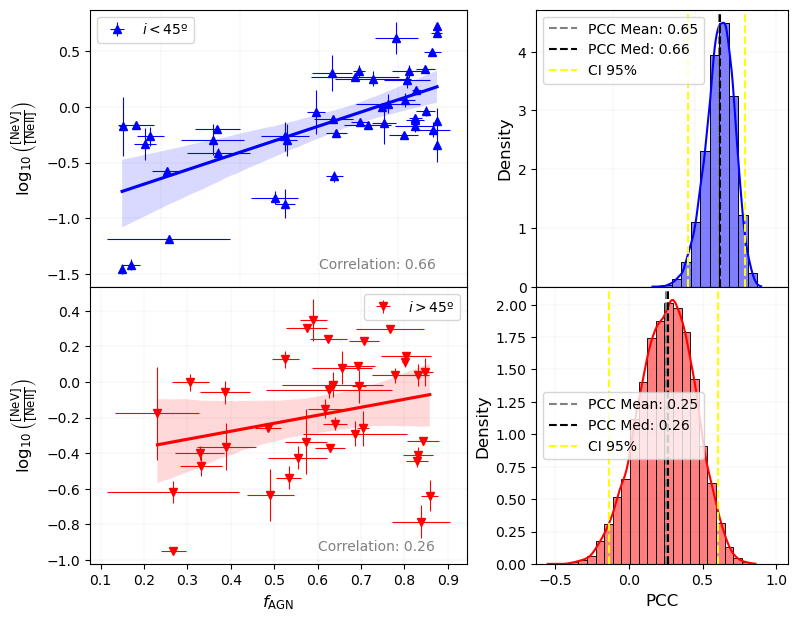

In [40]:
#plt.figure(figsize=(10,6.67))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(9,7.2),gridspec_kw={'width_ratios': [3,2]})

ax1 = plt.subplot(221)
ax1.errorbar(AGN_T1['bayes.agn.fracAGN'],AGN_T1['log_[NeV]/[NeII]'],
                AGN_T1['log_[NeV]/[NeII]_err'], AGN_T1['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='b^',label=r'$i<45$º')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=AGN_T1,
            ax=ax1,marker='*',color='b',scatter_kws={'s':2})
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.text(0.6,-1.45,'Correlation: %.2f' %r1T1_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.04)

ax2 = plt.subplot(222)
sns.histplot(r1_fracAGN_T1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax2)
ax2.axvline(x=r1_fracAGN_T1[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_T1[1])
ax2.axvline(x=r1_fracAGN_T1[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_T1[3])
ax2.axvline(x=r1_fracAGN_T1[4],ls='--',color='yellow',label='CI 95%')
ax2.axvline(x=r1_fracAGN_T1[5],ls='--',color='yellow')
ax2.set_ylabel(yr_label,fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.04)

ax3 = plt.subplot(223)#,sharex=ax1,sharey=ax1
ax3.errorbar(AGN_T2['bayes.agn.fracAGN'],AGN_T2['log_[NeV]/[NeII]'],
                AGN_T2['log_[NeV]/[NeII]_err'], AGN_T2['bayes.agn.fracAGN_err'],
                markersize=6,elinewidth=0.8,fmt='rv',label=r'$i>45$º')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=AGN_T2,
            ax=ax3,marker='*',color='r',scatter_kws={'s':2})
ax3.set_xlabel(xl_label,
               fontsize=fontsize_labels)
ax3.text(0.6,-0.95,'Correlation: %.2f' %r1T2_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.04)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(r1_fracAGN_Sy[0])
binsSy1 = sturges(r1_fracAGN_Sy1[0])
binsSy2 = sturges(r1_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(224)#,sharex=ax2,sharey=ax2
sns.histplot(r1_fracAGN_T2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax4)
ax4.axvline(x=r1_fracAGN_T2[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_T2[1])
ax4.axvline(x=r1_fracAGN_T2[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_T2[3])
ax4.axvline(x=r1_fracAGN_T2[4],ls='--',color='yellow',label='CI 95%')
ax4.axvline(x=r1_fracAGN_T2[5],ls='--',color='yellow')
ax4.set_xlabel('PCC',fontsize=fontsize_labels)
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.04)


plt.subplots_adjust(hspace=0.0,wspace=0.22) #Space between subplots

### $L^{disc}_{AGN}$ vs Redshift

Ramos et al. (2021) define a separation limit with the median values of the separation between Seyfert type as linear relation:

\begin{equation}
    \log \left(L^{disc}_{AGN} \right) = (9.20 \pm 0.08) + (8.67 \pm 0.61) \times \log(1+z)
\end{equation}

In [41]:
z = np.linspace(min(r1_Sy['redshift']),max(r1_Sy['redshift']),len(r1_Sy))
L = 9.20 + 8.67*np.log10(1+z)
L_u = (9.20-0.08) + (8.67-0.61)*np.log10(1+z)
L_o = (9.20+0.08) + (8.67+0.61)*np.log10(1+z)
len(L)

84

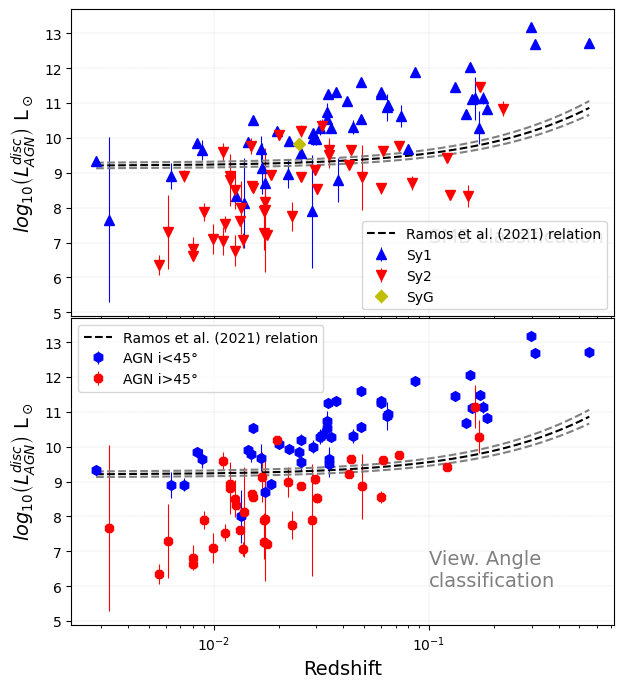

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,8),sharex=True)

ax1.set_xscale('log')
ax1.errorbar(Ne_Sy1['redshift'],Ne_Sy1['log_bayes.agn.disk_luminosity'],
             Ne_Sy1['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(Ne_Sy2['redshift'],Ne_Sy2['log_bayes.agn.disk_luminosity'],
             Ne_Sy2['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='rv',label='Sy2')
ax1.errorbar(Ne_SyG['redshift'],Ne_SyG['log_bayes.agn.disk_luminosity'],
             Ne_SyG['log_bayes.agn.disk_luminosity_err'],markersize=6,
             elinewidth=0.8,fmt='yD',label='SyG')
ax1.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax1.plot(z,L_u,ls='--',color='gray')
ax1.plot(z,L_o,ls='--',color='gray')
#ax1.set_xlabel(r'Redshift',fontsize=14)
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax1.text(1e-1,7,'SMB classification',fontsize=14,color='gray')
#ax1.set_title('Sy1 and Sy2 SMB classification', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.set_xscale('log')
ax2.errorbar(AGN_T1['redshift'],AGN_T1['log_bayes.agn.disk_luminosity'],
             AGN_T1['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='bh',label='AGN i<45°')
ax2.errorbar(AGN_T2['redshift'],AGN_T2['log_bayes.agn.disk_luminosity'],
             AGN_T2['log_bayes.agn.disk_luminosity_err'],markersize=7,
             elinewidth=0.8,fmt='r8',label='AGN i>45°')
ax2.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax2.plot(z,L_u,ls='--',color='gray')
ax2.plot(z,L_o,ls='--',color='gray')
ax2.set_xlabel(r'Redshift',fontsize=14)
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax2.text(1e-1,6,'View. Angle \nclassification',fontsize=14,color='gray')
#ax2.set_title('View. Angle classification', fontsize=14)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

plt.subplots_adjust(hspace=0.005) #Space between subplots
plt.savefig(path_graphs+'AGN_disc_L_vs_reshift.jpg')

### Classifying the galaxies by their AGN disc luminosity:

In [43]:
AGN_T1_L = r1_Sy[r1_Sy['log_bayes.agn.disk_luminosity'] > 9.20 + 8.67*np.log10(1+r1_Sy['redshift'])]
AGN_T2_L = r1_Sy[r1_Sy['log_bayes.agn.disk_luminosity'] < 9.20 + 8.67*np.log10(1+r1_Sy['redshift'])]

In [44]:
print('For the',len(AGN_T1_L),'galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity \
relation,',len(AGN_T1_L[AGN_T1_L['otype']=='Sy1']),'\nare Seyfert1 and',len(AGN_T1[AGN_T1['otype']=='Sy2']),\
      'are Seyfert2')

print('For the',len(AGN_T2_L),'galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity \
relation,',len(AGN_T2_L[AGN_T2_L['otype']=='Sy2']),'\nare Seyfert2 and',len(AGN_T2_L[AGN_T2_L['otype']=='Sy1']),\
      'are Seyfert1')

For the 47 galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity relation, 35 
are Seyfert1 and 10 are Seyfert2
For the 37 galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity relation, 29 
are Seyfert2 and 8 are Seyfert1


Just to check if we did the classification correctly, we will graph again the $L^{disc}_{AGN}$ vs Redshift:

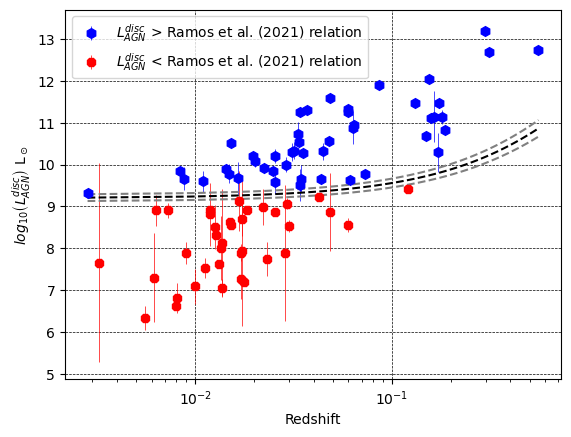

In [45]:
plt.figure()

plt.errorbar(AGN_T1_L['redshift'],AGN_T1_L['log_bayes.agn.disk_luminosity'],AGN_T1_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='bh',label=r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation')
plt.errorbar(AGN_T2_L['redshift'],AGN_T2_L['log_bayes.agn.disk_luminosity'],AGN_T2_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='r8',label=r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation')

plt.plot(z,L,ls='--',color='black')
plt.plot(z,L_u,ls='--',color='gray')
plt.plot(z,L_o,ls='--',color='gray')

plt.xlabel(r'Redshift')
plt.xscale('log')
plt.ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$')
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()

### [NeV]/[NeII] vs $f_{AGN}$ by their AGN disc luminosity:

In [46]:
r1T1L_fAGN_linreg = stats.linregress(AGN_T1_L['bayes.agn.fracAGN'],
                                     AGN_T1_L['log_[NeV]/[NeII]'])
r1T2L_fAGN_linreg = stats.linregress(AGN_T2_L['bayes.agn.fracAGN'],
                                     AGN_T2_L['log_[NeV]/[NeII]'])

In [47]:
r1T1L_fAGN_linreg

LinregressResult(slope=1.3202748799590602, intercept=-0.995101368496547, rvalue=0.6781939979284887, pvalue=1.6259829197035624e-07, stderr=0.2132663387376403, intercept_stderr=0.14752543513424798)

In [48]:
r1T2L_fAGN_linreg

LinregressResult(slope=0.34451377618578405, intercept=-0.39561964106759434, rvalue=0.23410937130129808, pvalue=0.1631293212885437, stderr=0.24183211544259683, intercept_stderr=0.14712494946138088)

In [49]:
r1_fracAGN_T1L = bsc.bootstrapCorr(10000,0.8,AGN_T1_L,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_T1L[0]),'max:',max(r1_fracAGN_T1L[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 38 of 47
Number of samples: 10000
Median: 0.6787335083757997
Mean: 0.6687798298407125
Variance: 0.009099428996212966
Standard Desviation: 0.09539092722168585
95 % confidence interval: 0.49587633101127687 - 0.8091796151756735
min: 0.18754563687050194 max: 0.9343376056563129


In [50]:
r1_fracAGN_T2L = bsc.bootstrapCorr(10000,0.8,AGN_T2_L,'bayes.agn.fracAGN','log_[NeV]/[NeII]')
print('min:',min(r1_fracAGN_T2L[0]),'max:',max(r1_fracAGN_T2L[0]))

Bootstraps results for the correlation coefficient between bayes.agn.fracAGN y log_[NeV]/[NeII] :
Samples lenght: 30 of 37
Number of samples: 10000
Median: 0.23869322209061428
Mean: 0.23308422090641176
Variance: 0.032354305482734366
Standard Desviation: 0.17987302600093868
95 % confidence interval: -0.07408631949840377 - 0.5177902112136192
min: -0.3909430141870985 max: 0.7872527387373462


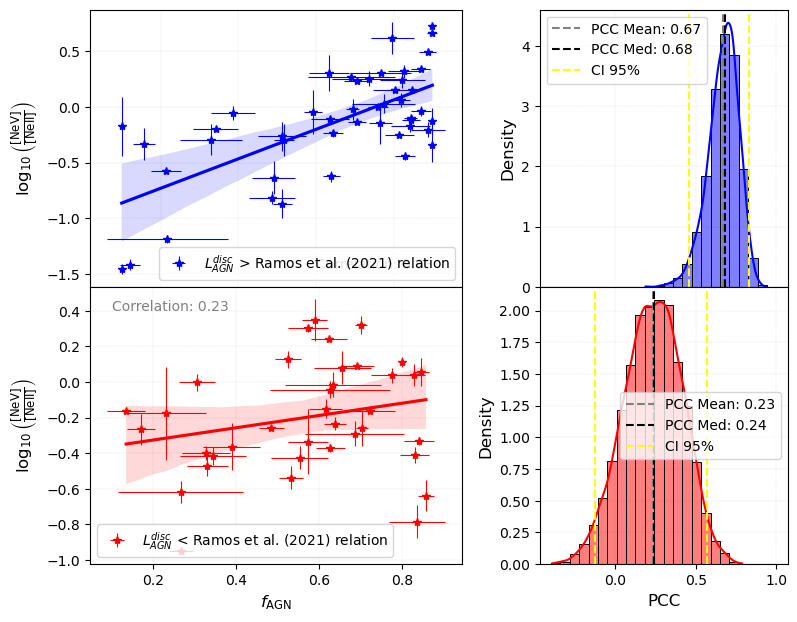

In [51]:
#plt.figure(figsize=(10,6.67))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(9,7.2),gridspec_kw={'width_ratios': [3,2]})

ax1 = plt.subplot(221)
ax1.errorbar(AGN_T1_L['bayes.agn.fracAGN'],AGN_T1_L['log_[NeV]/[NeII]'],
             AGN_T1_L['log_[NeV]/[NeII]_err'], AGN_T1_L['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='b*',
             label=r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=AGN_T1_L,
            ax=ax1,marker='*',color='b',scatter_kws={'s':2})
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.text(0.6,-1.45,'Correlation: %.2f' %r1T1L_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.04)

ax2 = plt.subplot(222)
sns.histplot(r1_fracAGN_T1L[0],kde=True,bins=bins,stat=stat,color='b',ax=ax2)
ax2.axvline(x=r1_fracAGN_T1L[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_T1L[1])
ax2.axvline(x=r1_fracAGN_T1L[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_T1L[3])
ax2.axvline(x=r1_fracAGN_T1L[4],ls='--',color='yellow',label='CI 95%')
ax2.axvline(x=r1_fracAGN_T1L[5],ls='--',color='yellow')
ax2.set_ylabel(yr_label,fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.04)

ax3 = plt.subplot(223)#,sharex=ax1,sharey=ax1
ax3.errorbar(AGN_T2_L['bayes.agn.fracAGN'],AGN_T2_L['log_[NeV]/[NeII]'],
             AGN_T2_L['log_[NeV]/[NeII]_err'], AGN_T2_L['bayes.agn.fracAGN_err'],
             markersize=6,elinewidth=0.8,fmt='r*',
             label=r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation')
sns.regplot(x='bayes.agn.fracAGN',y="log_[NeV]/[NeII]",data=AGN_T2_L,
            ax=ax3,marker='*',color='r',scatter_kws={'s':2})
ax3.set_xlabel(xl_label,
               fontsize=fontsize_labels)
ax3.text(0.1,0.4,'Correlation: %.2f' %r1T2L_fAGN_linreg.rvalue,fontsize=10,color='gray')
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.04)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(r1_fracAGN_Sy[0])
binsSy1 = sturges(r1_fracAGN_Sy1[0])
binsSy2 = sturges(r1_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(224)#,sharex=ax2,sharey=ax2
sns.histplot(r1_fracAGN_T2L[0],kde=True,bins=bins,stat=stat,color='r',ax=ax4)
ax4.axvline(x=r1_fracAGN_T2L[1],ls='--',color='gray',label='PCC Mean: %.2f' %r1_fracAGN_T2L[1])
ax4.axvline(x=r1_fracAGN_T2L[3],ls='--',color='black',label='PCC Med: %.2f' %r1_fracAGN_T2L[3])
ax4.axvline(x=r1_fracAGN_T2L[4],ls='--',color='yellow',label='CI 95%')
ax4.axvline(x=r1_fracAGN_T2L[5],ls='--',color='yellow')
ax4.set_xlabel('PCC',fontsize=fontsize_labels)
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.04)


plt.subplots_adjust(hspace=0.0,wspace=0.25) #Space between subplots

--------------------------

## $L^{disc}_{AGN}$ vs $i$

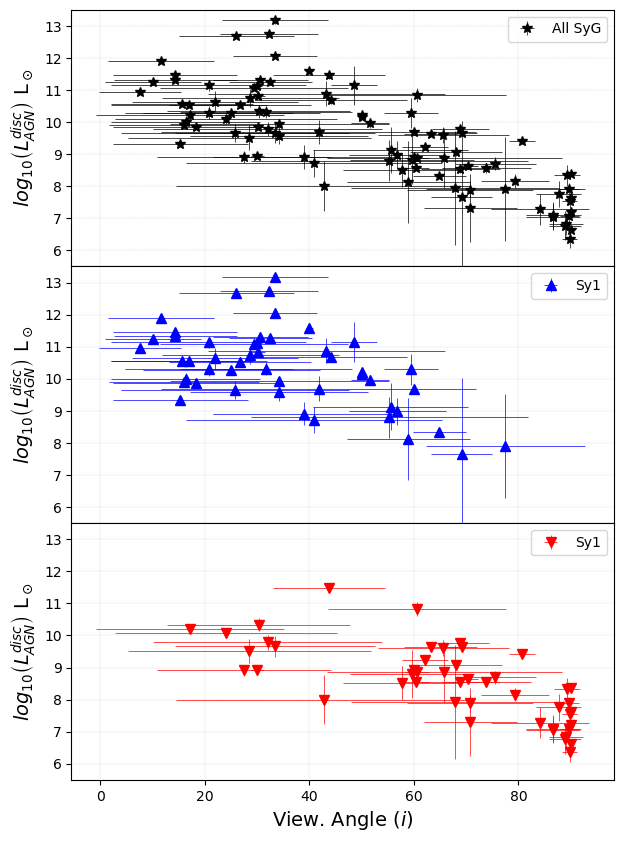

In [52]:
fig, (ax1, ax2, ax3,) = plt.subplots(3,1,figsize=(7,10),sharex=True)
#fig.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

ax1.errorbar(Ne_Sy['bayes.agn.i'], Ne_Sy['log_bayes.agn.disk_luminosity'],Ne_Sy['log_bayes.agn.disk_luminosity_err'], Ne_Sy['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='k*',label='All SyG')
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax1.set_ylim(5.5,13.5)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.errorbar(Ne_Sy1['bayes.agn.i'], Ne_Sy1['log_bayes.agn.disk_luminosity'],Ne_Sy1['log_bayes.agn.disk_luminosity_err'], Ne_Sy1['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='b^',label='Sy1')
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax2.set_ylim(5.5,13.5)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

ax3.errorbar(Ne_Sy2['bayes.agn.i'], Ne_Sy2['log_bayes.agn.disk_luminosity'],Ne_Sy2['log_bayes.agn.disk_luminosity_err'], Ne_Sy2['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='rv',label='Sy1')
ax3.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax3.set_xlabel(r'View. Angle ($i$)', fontsize=14)
ax3.set_ylim(5.5,13.5)
ax3.grid(color='k', linestyle='--', linewidth=0.05)
ax3.legend()

plt.subplots_adjust(hspace=0.001) #Space between subplots

Bootstraps results for the correlation coefficient between bayes.agn.i y log_bayes.agn.disk_luminosity :
Samples lenght: 78 of 97
Number of samples: 10000
Median: -0.7800544818816804
Mean: -0.7772191025263266
Variance: 0.001501252001214012
Standard Desviation: 0.038745993356913845
95 % confidence interval: -0.8353575245039574 - -0.7088455041133096


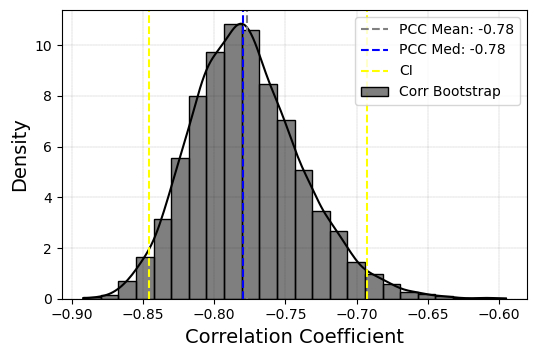

In [53]:
LAGNdisc_i_Sy = bsc.bootstrapCorr(10000,0.8,Ne_Sy,'bayes.agn.i','log_bayes.agn.disk_luminosity',kdehisto=True)

-------------------------------------
## Notebook Info

In [54]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.14.0

Compiler    : GCC 13.2.1 20231205 (Red Hat 13.2.1-6)
OS          : Linux
Release     : 6.6.7-200.fc39.x86_64
Machine     : x86_64
Processor   : 
CPU cores   : 16
Architecture: 64bit

Specific Python packages
astropy: 5.3.2

scipy     : 1.11.1
astropy   : 5.3.2
numpy     : 1.24.4
seaborn   : 0.13.0
matplotlib: 3.8.2

Watermark: 2.4.3



-----------------------------------------
### Cells for test

-------------------------------